In [1]:
#Import libraries to open data file
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer, balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from statistics import mean as stat_mean
from numpy import mean
from numpy import std

### One vs all classification: for feature selection

### Normalized Data

#### For AFFF-GW

In [2]:
data_rf = pd.read_csv(r'240905-NTA-Paper2-AnnotatedFeatures-ONLY-LogT-Input.csv', header=0) #Targets: 92 samples X 581 features
#del data_rf[data_rf.columns[0]] #Dropping sample information
#print(data_rf)

In [3]:
#Prompt user for source type of interest (AFFF-GW, LF, BSL, WWTP, PP or PG)
preferred_type = input("Enter the source type of interest: ")

Enter the source type of interest: AFFF-GW


In [4]:
#Manipulating data frame based on user input to make "Type" column read 1 for all samples of source of interest and 0 for all other samples
#Set up for binary classification (one-vs-all format)

# Define a function to apply to each row
def set_type(row):
    if row['Type'] == preferred_type:
        return 1
    else:
        return 0

# Create a new column "Type 2" with the updated values
data_rf['Type_2'] = data_rf.apply(set_type, axis=1)
del data_rf[data_rf.columns[0]] #Dropping original type column
#Reordering columns with Type_2 as first column
cols = list(data_rf.columns)
cols = [cols[-1]] + cols[:-1]
data_rf = data_rf[cols]

# Save the updated DataFrame to a new CSV file (if needed)
data_rf.to_csv('sample_data_with_labels_NEW10.csv', index=False)

In [5]:
#Changing pandas data frame to numpy for use in ML
data_rf_np = data_rf.to_numpy()
target_1 = data_rf_np[:,0].reshape(-1,1) #Convert target variables to 2D-array for sci-kit learn
data_1 = data_rf_np[:,1:]

#class_names=np.array([0.0,1.0])
#print(data_1.shape)
#print(data_1)
#data_1 = pd.DataFrame(data_1)
#data_1.to_csv('log10_dat.csv', index=False)

In [6]:
# Split into test and training, and evaluate optimal hyperparameters for Random Forest
totalR = 10
rs = np.arange(1, totalR + 1)

# Define hyperparameter grid for Logistic Regression
solver = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l1','l2']
C_val = [100, 10, 1.0, 0.1, 0.01]

grid = dict(solver=solver,penalty=penalty,C=C_val)

balanced_accuracy_scorer = make_scorer(balanced_accuracy_score)
# Initialize arrays to store results
test_balanced_accuracy = np.empty(len(rs))
train_balanced_accuracy = np.empty(len(rs))



for j in rs:
    X_train, X_test, y_train, y_test = train_test_split(
        data_1, target_1, test_size=0.2, stratify=target_1, random_state=j)
    
    # Create Random Forest classifier
    rf = LogisticRegression()
    
    # Create repeated stratified k-fold cross-validator
    cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=5, random_state=42)
    
    # Perform hyperparameter tuning with GridSearchCV
    grid_search = GridSearchCV(estimator=rf, param_grid=grid, n_jobs=-1, cv=cv, scoring=balanced_accuracy_scorer, error_score=0)
    grid_result = grid_search.fit(X_train, y_train.ravel())
    
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

    # Get the best Logsistic regression model from GridSearchCV
    best_rf = grid_search.best_estimator_

    # Compute balanced accuracy on the training and test data
    train_predictions = best_rf.predict(X_train)
    test_predictions = best_rf.predict(X_test)
    
    train_ba = balanced_accuracy_score(y_train, train_predictions)
    test_ba = balanced_accuracy_score(y_test, test_predictions)
    
    train_balanced_accuracy[j-1] = train_ba
    test_balanced_accuracy[j-1] = test_ba

C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
150 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueErr

Best: 0.958333 using {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}


C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
150 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueErr

Best: 0.966667 using {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}


C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
150 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueErr

Best: 0.933333 using {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}


C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
150 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueErr

Best: 0.948333 using {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}


C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
150 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueErr

Best: 0.941667 using {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}


C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
150 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueErr

Best: 0.975000 using {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}


C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
150 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueErr

Best: 0.916667 using {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}


C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
150 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueErr

Best: 0.950000 using {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}


C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
150 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueErr

Best: 1.000000 using {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
Best: 0.950000 using {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}


C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
150 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueErr

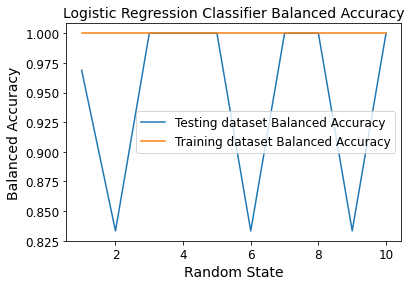

Best Testing Balanced Accuracy: 1.0
Corresponding Random State: 3


In [7]:
# Plot balanced accuracy for different random states
plt.plot(rs, test_balanced_accuracy, label='Testing dataset Balanced Accuracy')
plt.plot(rs, train_balanced_accuracy, label='Training dataset Balanced Accuracy')

plt.legend(fontsize=12)
plt.title('Logistic Regression Classifier Balanced Accuracy', fontsize=14)
plt.xlabel('Random State', fontsize=14)
plt.ylabel('Balanced Accuracy', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig('lR-Tuning-NORM-GW.png', dpi=150, bbox_inches='tight')
plt.show()

# Print the value of best balanced accuracy and the corresponding random state
best_test_balanced_accuracy = np.max(test_balanced_accuracy)
best_random_state = rs[np.argmax(test_balanced_accuracy)]
print("Best Testing Balanced Accuracy:", best_test_balanced_accuracy)
print("Corresponding Random State:", best_random_state)

In [8]:
print(train_balanced_accuracy)
print(test_balanced_accuracy)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[0.96875    0.83333333 1.         1.         1.         0.83333333
 1.         1.         0.83333333 1.        ]


Feature: 0, Score: -0.23461
Feature: 1, Score: 0.17539
Feature: 2, Score: 0.71151
Feature: 3, Score: 0.48051
Feature: 4, Score: 0.44865
Feature: 5, Score: -0.13573
Feature: 6, Score: -0.06208
Feature: 7, Score: 0.59861
Feature: 8, Score: -0.19940
Feature: 9, Score: 0.51123
Feature: 10, Score: 1.01106
Feature: 11, Score: 0.55068
Feature: 12, Score: 0.02462
Feature: 13, Score: 0.49514
Feature: 14, Score: 0.56243
Feature: 15, Score: 0.26149
Feature: 16, Score: -0.00751
Feature: 17, Score: -0.04126
Feature: 18, Score: 0.31382
Feature: 19, Score: 0.21109
Feature: 20, Score: 0.66179
Feature: 21, Score: 0.02368
Feature: 22, Score: 0.10709
Feature: 23, Score: 0.01864
Feature: 24, Score: 0.08502
Feature: 25, Score: -0.15677
Feature: 26, Score: 0.03810
Feature: 27, Score: 0.12550
Feature: 28, Score: -0.13724
Feature: 29, Score: -0.17577
Feature: 30, Score: -0.22444
Feature: 31, Score: 0.01809
Feature: 32, Score: 0.06503
Feature: 33, Score: -0.27852
Feature: 34, Score: 0.01710
Feature: 35, Score:

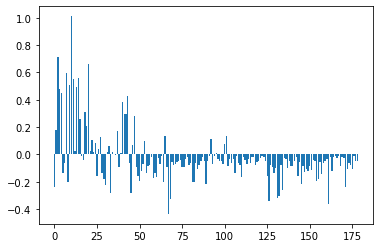

In [9]:
#Now running optimized model over the entire dataset
model = LogisticRegression(solver = 'newton-cg', C = 100, penalty = 'l2')
# fit the model
model.fit(data_1, target_1.ravel())

# get importance
importance = model.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

Feature 0: Average Score: -0.23461, Standard Deviation: 0.00000
Feature 1: Average Score: 0.17539, Standard Deviation: 0.00000
Feature 2: Average Score: 0.71151, Standard Deviation: 0.00000
Feature 3: Average Score: 0.48051, Standard Deviation: 0.00000
Feature 4: Average Score: 0.44865, Standard Deviation: 0.00000
Feature 5: Average Score: -0.13573, Standard Deviation: 0.00000
Feature 6: Average Score: -0.06208, Standard Deviation: 0.00000
Feature 7: Average Score: 0.59861, Standard Deviation: 0.00000
Feature 8: Average Score: -0.19940, Standard Deviation: 0.00000
Feature 9: Average Score: 0.51123, Standard Deviation: 0.00000
Feature 10: Average Score: 1.01106, Standard Deviation: 0.00000
Feature 11: Average Score: 0.55068, Standard Deviation: 0.00000
Feature 12: Average Score: 0.02462, Standard Deviation: 0.00000
Feature 13: Average Score: 0.49514, Standard Deviation: 0.00000
Feature 14: Average Score: 0.56243, Standard Deviation: 0.00000
Feature 15: Average Score: 0.26149, Standard D

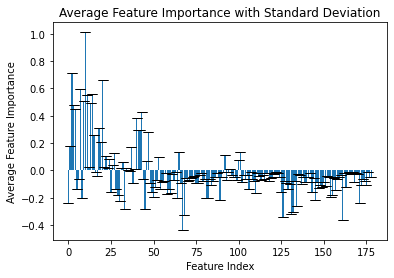

In [10]:
# Initialize variables to store feature importances across iterations
all_importances = []

# Number of iterations
num_iterations = 100

for iteration in range(num_iterations):
    # Create and fit the model
    model = LogisticRegression(solver = 'newton-cg', C = 100, penalty = 'l2')
    model.fit(data_1, target_1.ravel())

    # Get importance and store in the list
    importance = model.coef_[0]
    all_importances.append(importance)

# Convert the list to a NumPy array for easy calculations
all_importances = np.array(all_importances)

# Calculate average and standard deviation of feature importances
average_importance = np.mean(all_importances, axis=0)
std_importance = np.std(all_importances, axis=0)

# Summarize and print feature importance statistics
for i, (avg_score, std_score) in enumerate(zip(average_importance, std_importance)):
    print(f'Feature {i}: Average Score: {avg_score:.5f}, Standard Deviation: {std_score:.5f}')

# Plot the average feature importance
plt.bar([x for x in range(len(average_importance))], average_importance, yerr=std_importance, capsize=5)
plt.xlabel('Feature Index')
plt.ylabel('Average Feature Importance')
plt.title('Average Feature Importance with Standard Deviation')
plt.show()

In [11]:
labels_dat = pd.read_csv("240905-NTA-Paper2-AnnotatedFeatures-ONLY-Labels.csv")
feature_names = labels_dat.columns

feature_importance_pairs = [(avg, std, name) for avg, std, name in zip(average_importance, std_importance, feature_names)]

# Sort the list by average importance in descending order
feature_importance_pairs.sort(reverse=True, key=lambda x: x[0])

# Print the output for the top 10 features
print("Top 10 Features:")
for avg, std, name in feature_importance_pairs[:10]:
    print(f'Feature: {name}, Mean Score: {avg:.5f}, Standard Deviation: {std:.5f}')

Top 10 Features:
Feature: 397.951243/11.28, Mean Score: 1.01106, Standard Deviation: 0.00000
Feature: 398.935583/8.9, Mean Score: 0.71151, Standard Deviation: 0.00000
Feature: 448.932612/10.45, Mean Score: 0.66179, Standard Deviation: 0.00000
Feature: 498.929561/11.43, Mean Score: 0.59861, Standard Deviation: 0.00000
Feature: 397.951371/10.99, Mean Score: 0.56243, Standard Deviation: 0.00000
Feature: 143.107393/8.12, Mean Score: 0.55068, Standard Deviation: 0.00000
Feature: 298.942577/7.31, Mean Score: 0.51123, Standard Deviation: 0.00000
Feature: 312.972236/8.1, Mean Score: 0.49514, Standard Deviation: 0.00000
Feature: 412.965446/10.35, Mean Score: 0.48051, Standard Deviation: 0.00000
Feature: 348.939226/8.16, Mean Score: 0.44865, Standard Deviation: 0.00000


In [12]:
labels_dat = pd.read_csv("240905-NTA-Paper2-AnnotatedFeatures-ONLY-Labels.csv")
feature_names = labels_dat.columns

# Get indices of the top 10 features based on mean importance
top_10_indices = np.argsort(average_importance)[::-1][:10]

# Print top 10 features along with their average and standard deviation
print("Top 10 Features:")
for i in top_10_indices:
    print(f'Feature: {feature_names[i]}, Mean Score: {average_importance[i]:.5f}, Standard Deviation: {std_importance[i]:.5f}')

Top 10 Features:
Feature: 397.951243/11.28, Mean Score: 1.01106, Standard Deviation: 0.00000
Feature: 398.935583/8.9, Mean Score: 0.71151, Standard Deviation: 0.00000
Feature: 448.932612/10.45, Mean Score: 0.66179, Standard Deviation: 0.00000
Feature: 498.929561/11.43, Mean Score: 0.59861, Standard Deviation: 0.00000
Feature: 397.951371/10.99, Mean Score: 0.56243, Standard Deviation: 0.00000
Feature: 143.107393/8.12, Mean Score: 0.55068, Standard Deviation: 0.00000
Feature: 298.942577/7.31, Mean Score: 0.51123, Standard Deviation: 0.00000
Feature: 312.972236/8.1, Mean Score: 0.49514, Standard Deviation: 0.00000
Feature: 412.965446/10.35, Mean Score: 0.48051, Standard Deviation: 0.00000
Feature: 348.939226/8.16, Mean Score: 0.44865, Standard Deviation: 0.00000


Top Features with Significant Importance:
1. Feature: 397.951243/11.28, Mean Score: 1.01106, Standard Deviation: 0.00000
2. Feature: 398.935583/8.9, Mean Score: 0.71151, Standard Deviation: 0.00000
3. Feature: 448.932612/10.45, Mean Score: 0.66179, Standard Deviation: 0.00000
4. Feature: 498.929561/11.43, Mean Score: 0.59861, Standard Deviation: 0.00000
5. Feature: 397.951371/10.99, Mean Score: 0.56243, Standard Deviation: 0.00000
6. Feature: 143.107393/8.12, Mean Score: 0.55068, Standard Deviation: 0.00000
7. Feature: 298.942577/7.31, Mean Score: 0.51123, Standard Deviation: 0.00000
8. Feature: 312.972236/8.1, Mean Score: 0.49514, Standard Deviation: 0.00000
9. Feature: 412.965446/10.35, Mean Score: 0.48051, Standard Deviation: 0.00000
10. Feature: 348.939226/8.16, Mean Score: 0.44865, Standard Deviation: 0.00000
11. Feature: 313.00854/8.08, Mean Score: 0.43037, Standard Deviation: 0.00000
12. Feature: 398.87446/9.14, Mean Score: 0.38147, Standard Deviation: 0.00000
13. Feature: 362.9

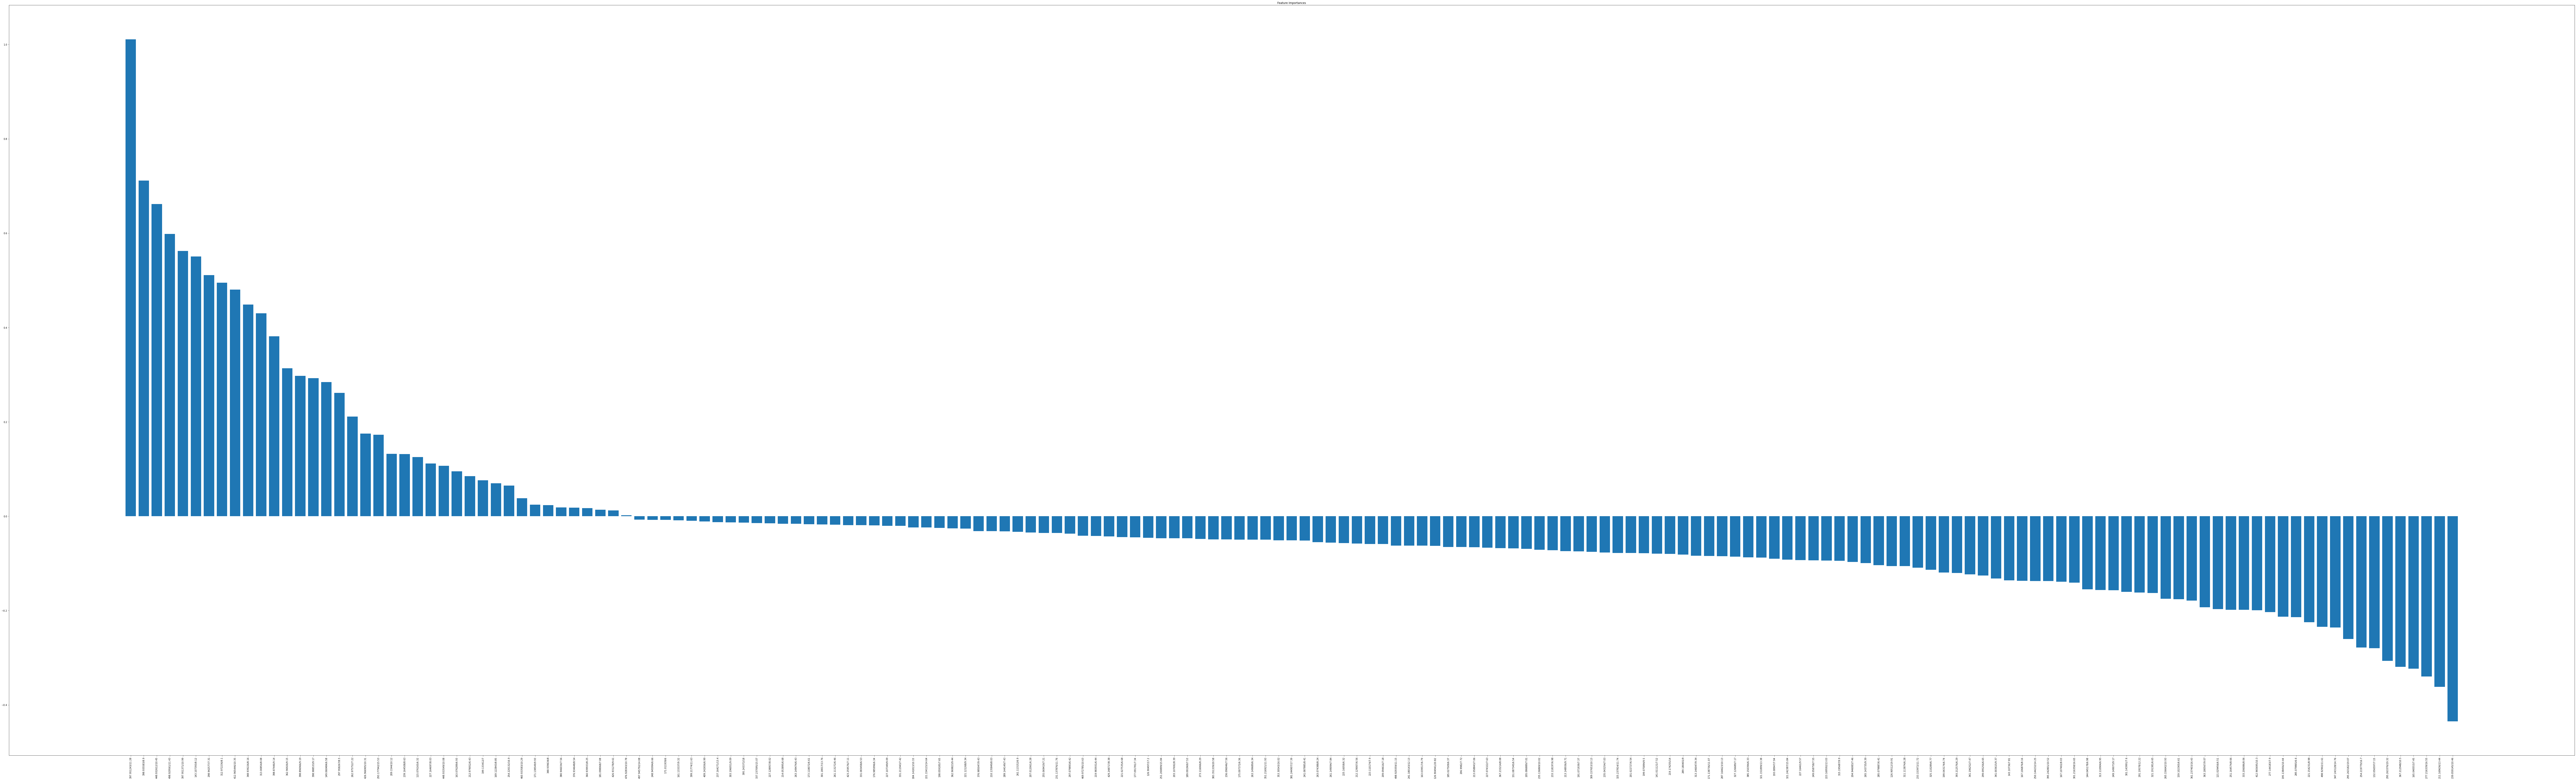

In [13]:
# Rank features by importance
sorted_feature_importance_pairs = sorted(feature_importance_pairs, reverse=True, key=lambda x: x[0])

# Extract feature names and importances
sorted_importances, _, sorted_feature_names = zip(*sorted_feature_importance_pairs)

# Convert feature importances to a numeric data type
sorted_importances = np.array(sorted_importances, dtype=float)

# Calculate the difference between subsequent feature importances
importance_diff = np.diff(sorted_importances)

# Find the index where the largest decrease occurs
largest_decrease_index = np.argmax(importance_diff)


# Store the top features and scores in a DataFrame
df_top_features = pd.DataFrame({'Feature': [], 'Score': []})

# Print the top features until the largest decrease
print("Top Features with Significant Importance:")
for i, (avg, std, name) in enumerate(sorted_feature_importance_pairs[:largest_decrease_index + 1], 1):
    try:
        avg_float = float(avg)
        print(f"{i}. Feature: {name}, Mean Score: {avg_float:.5f}, Standard Deviation: {std:.5f}")
        df_top_features = df_top_features.append({'Feature': name, 'Score': avg_float}, ignore_index=True)
    except ValueError:
        print(f"{i}. Feature: {name}, Mean Score: {avg}, Standard Deviation: {std} (non-numeric)")

# Save the df_top_features DataFrame to an Excel file
df_top_features.to_excel('top_features_scores_norm_GW.xlsx', index=False)

# Plot feature importance
plt.figure(figsize=(200, 60))
plt.bar(range(len(sorted_importances)), sorted_importances, tick_label=sorted_feature_names)
plt.xticks(rotation=90)
plt.title("Feature Importances")
# Save the figure as a PNG file
plt.savefig('feature_importances_plot_ORDERED_norm_GW.png', bbox_inches='tight')

# Show the plot (optional)
plt.show()

In [14]:
df = pd.DataFrame({'Importance Difference': importance_diff})
df.to_excel('importance_diff_norm_GW.xlsx', index=False)

In [15]:
class_names=np.array([0.0,1.0])

#Generating confusion matrices (for entire dataset; normalized BAs)
def evaluate_model(data_x, data_y):
    k_fold = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

    predicted_targets = np.array([])
    actual_targets = np.array([])

    for train_ix, test_ix in k_fold.split(data_x, data_y):
        train_x, train_y, test_x, test_y = data_x[train_ix], data_y[train_ix], data_x[test_ix], data_y[test_ix]

        # Fit the classifier
        model_cv = LogisticRegression(solver = 'newton-cg', C = 100, penalty = 'l2')
        classifier = model_cv.fit(train_x, train_y.ravel())

        # Predict the labels of the test set samples
        predicted_labels = classifier.predict(test_x)

        predicted_targets = np.append(predicted_targets, predicted_labels)
        actual_targets = np.append(actual_targets, test_y)

    return predicted_targets, actual_targets

In [16]:
def plot_confusion_matrix(predicted_labels_list, y_test_list):
    cnf_matrix = confusion_matrix(y_test_list, predicted_labels_list)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure()
    generate_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix, without normalization')
    plt.show()

    # Plot normalized confusion matrix
    plt.figure()
    generate_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, title='Normalized confusion matrix')
    plt.show()

In [17]:
def generate_confusion_matrix(cnf_matrix, classes, normalize=False, title='Confusion matrix'):
    if normalize:
        cnf_matrix = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cnf_matrix, interpolation='nearest', cmap=plt.get_cmap('Blues'))
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cnf_matrix.max() / 2.
    
    for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        plt.text(j, i, format(cnf_matrix[i, j], fmt), horizontalalignment="center",
                 color="white" if cnf_matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    return cnf_matrix

Confusion matrix, without normalization


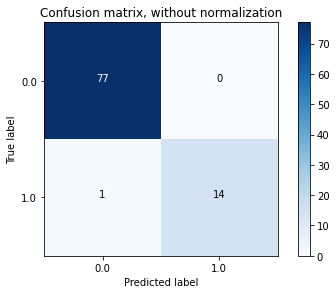

Normalized confusion matrix


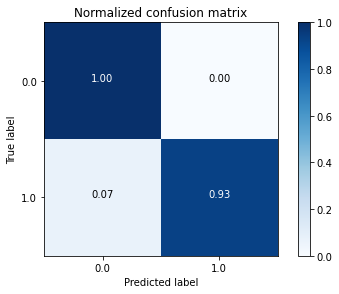

In [18]:
predicted_target, actual_target = evaluate_model(data_1, target_1)
plot_confusion_matrix(predicted_target, actual_target)

#### For LL

In [19]:
data_rf = pd.read_csv(r'240905-NTA-Paper2-AnnotatedFeatures-ONLY-LogT-Input.csv', header=0) #Targets: 92 samples X 581 features
#del data_rf[data_rf.columns[0]] #Dropping sample information
#print(data_rf)

In [20]:
#Prompt user for source type of interest (GW, LL, BL, WWTP, PP or PG)
preferred_type = input("Enter the source type of interest: ")

Enter the source type of interest: LL


In [21]:
#Manipulating data frame based on user input to make "Type" column read 1 for all samples of source of interest and 0 for all other samples
#Set up for binary classification (one-vs-all format)

# Define a function to apply to each row
def set_type(row):
    if row['Type'] == preferred_type:
        return 1
    else:
        return 0

# Create a new column "Type 2" with the updated values
data_rf['Type_2'] = data_rf.apply(set_type, axis=1)
del data_rf[data_rf.columns[0]] #Dropping original type column
#Reordering columns with Type_2 as first column
cols = list(data_rf.columns)
cols = [cols[-1]] + cols[:-1]
data_rf = data_rf[cols]

# Save the updated DataFrame to a new CSV file (if needed)
data_rf.to_csv('sample_data_with_labels_NEW10.csv', index=False)

In [22]:
#Changing pandas data frame to numpy for use in ML
data_rf_np = data_rf.to_numpy()
target_1 = data_rf_np[:,0].reshape(-1,1) #Convert target variables to 2D-array for sci-kit learn
data_1 = data_rf_np[:,1:]
#class_names=np.array([0.0,1.0])
#print(data_1.shape)
#print(data_1)

In [23]:
# Split into test and training, and evaluate optimal hyperparameters for Random Forest
totalR = 10
rs = np.arange(1, totalR + 1)

# Define hyperparameter grid for Logistic Regression
solver = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l1','l2']
C_val = [100, 10, 1.0, 0.1, 0.01]

grid = dict(solver=solver,penalty=penalty,C=C_val)

balanced_accuracy_scorer = make_scorer(balanced_accuracy_score)
# Initialize arrays to store results
test_balanced_accuracy = np.empty(len(rs))
train_balanced_accuracy = np.empty(len(rs))



for j in rs:
    X_train, X_test, y_train, y_test = train_test_split(
        data_1, target_1, test_size=0.2, stratify=target_1, random_state=j)
    
    # Create Random Forest classifier
    rf = LogisticRegression()
    
    # Create repeated stratified k-fold cross-validator
    cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=5, random_state=42)
    
    # Perform hyperparameter tuning with GridSearchCV
    grid_search = GridSearchCV(estimator=rf, param_grid=grid, n_jobs=-1, cv=cv, scoring=balanced_accuracy_scorer, error_score=0)
    grid_result = grid_search.fit(X_train, y_train.ravel())
    
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

    # Get the best Logsistic regression model from GridSearchCV
    best_rf = grid_search.best_estimator_

    # Compute balanced accuracy on the training and test data
    train_predictions = best_rf.predict(X_train)
    test_predictions = best_rf.predict(X_test)
    
    train_ba = balanced_accuracy_score(y_train, train_predictions)
    test_ba = balanced_accuracy_score(y_test, test_predictions)
    
    train_balanced_accuracy[j-1] = train_ba
    test_balanced_accuracy[j-1] = test_ba

C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
150 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueErr

Best: 0.966667 using {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}


C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
150 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueErr

Best: 0.966667 using {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}


C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
150 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueErr

Best: 0.966667 using {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}


C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
150 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueErr

Best: 0.966667 using {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}


C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
150 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueErr

Best: 0.953333 using {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}


C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
150 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueErr

Best: 0.966667 using {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}


C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
150 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueErr

Best: 0.966667 using {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}


C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
150 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueErr

Best: 0.933333 using {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}


C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
150 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueErr

Best: 0.966667 using {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
Best: 0.966667 using {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}


C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
150 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueErr

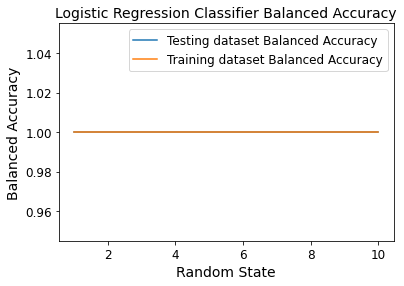

Best Testing Balanced Accuracy: 1.0
Corresponding Random State: 1


In [24]:
# Plot balanced accuracy for different random states
plt.plot(rs, test_balanced_accuracy, label='Testing dataset Balanced Accuracy')
plt.plot(rs, train_balanced_accuracy, label='Training dataset Balanced Accuracy')

plt.legend(fontsize=12)
plt.title('Logistic Regression Classifier Balanced Accuracy', fontsize=14)
plt.xlabel('Random State', fontsize=14)
plt.ylabel('Balanced Accuracy', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig('lR-Tuning-NORM-LL.png', dpi=150, bbox_inches='tight')
plt.show()

# Print the value of best balanced accuracy and the corresponding random state
best_test_balanced_accuracy = np.max(test_balanced_accuracy)
best_random_state = rs[np.argmax(test_balanced_accuracy)]
print("Best Testing Balanced Accuracy:", best_test_balanced_accuracy)
print("Corresponding Random State:", best_random_state)

In [25]:
print(train_balanced_accuracy)
print(test_balanced_accuracy)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


Feature: 0, Score: -0.34177
Feature: 1, Score: -0.03137
Feature: 2, Score: -0.05734
Feature: 3, Score: 0.28572
Feature: 4, Score: -0.11474
Feature: 5, Score: 0.09510
Feature: 6, Score: -0.01110
Feature: 7, Score: -0.23342
Feature: 8, Score: -0.15363
Feature: 9, Score: -0.10955
Feature: 10, Score: -0.22346
Feature: 11, Score: -0.50912
Feature: 12, Score: -0.09513
Feature: 13, Score: 0.36400
Feature: 14, Score: -0.11914
Feature: 15, Score: -0.13211
Feature: 16, Score: -0.04912
Feature: 17, Score: -0.09093
Feature: 18, Score: -0.11470
Feature: 19, Score: 0.23317
Feature: 20, Score: -0.19128
Feature: 21, Score: -0.07873
Feature: 22, Score: -0.06572
Feature: 23, Score: -0.04479
Feature: 24, Score: 0.05733
Feature: 25, Score: 0.24730
Feature: 26, Score: -0.07799
Feature: 27, Score: -0.28052
Feature: 28, Score: 0.23115
Feature: 29, Score: -0.34784
Feature: 30, Score: 0.23015
Feature: 31, Score: -0.06364
Feature: 32, Score: -0.30547
Feature: 33, Score: -0.35564
Feature: 34, Score: -0.06004
Fea

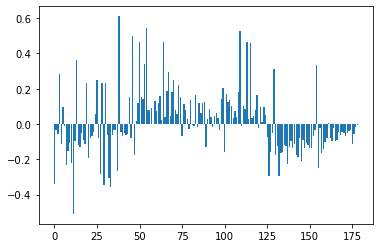

In [26]:
#Now running optimized model over the entire dataset
model = LogisticRegression(solver = 'newton-cg', C = 100, penalty = 'l2')
# fit the model
model.fit(data_1, target_1.ravel())

# get importance
importance = model.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

Feature 0: Average Score: -0.34177, Standard Deviation: 0.00000
Feature 1: Average Score: -0.03137, Standard Deviation: 0.00000
Feature 2: Average Score: -0.05734, Standard Deviation: 0.00000
Feature 3: Average Score: 0.28572, Standard Deviation: 0.00000
Feature 4: Average Score: -0.11474, Standard Deviation: 0.00000
Feature 5: Average Score: 0.09510, Standard Deviation: 0.00000
Feature 6: Average Score: -0.01110, Standard Deviation: 0.00000
Feature 7: Average Score: -0.23342, Standard Deviation: 0.00000
Feature 8: Average Score: -0.15363, Standard Deviation: 0.00000
Feature 9: Average Score: -0.10955, Standard Deviation: 0.00000
Feature 10: Average Score: -0.22346, Standard Deviation: 0.00000
Feature 11: Average Score: -0.50912, Standard Deviation: 0.00000
Feature 12: Average Score: -0.09513, Standard Deviation: 0.00000
Feature 13: Average Score: 0.36400, Standard Deviation: 0.00000
Feature 14: Average Score: -0.11914, Standard Deviation: 0.00000
Feature 15: Average Score: -0.13211, S

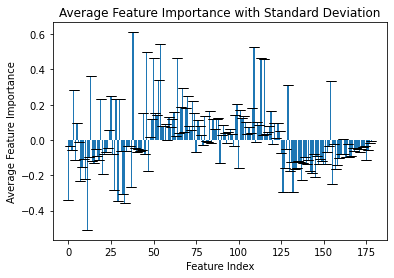

In [27]:
# Initialize variables to store feature importances across iterations
all_importances = []

# Number of iterations
num_iterations = 100

for iteration in range(num_iterations):
    # Create and fit the model
    model = LogisticRegression(solver = 'newton-cg', C = 100, penalty = 'l2')
    model.fit(data_1, target_1.ravel())

    # Get importance and store in the list
    importance = model.coef_[0]
    all_importances.append(importance)

# Convert the list to a NumPy array for easy calculations
all_importances = np.array(all_importances)

# Calculate average and standard deviation of feature importances
average_importance = np.mean(all_importances, axis=0)
std_importance = np.std(all_importances, axis=0)

# Summarize and print feature importance statistics
for i, (avg_score, std_score) in enumerate(zip(average_importance, std_importance)):
    print(f'Feature {i}: Average Score: {avg_score:.5f}, Standard Deviation: {std_score:.5f}')

# Plot the average feature importance
plt.bar([x for x in range(len(average_importance))], average_importance, yerr=std_importance, capsize=5)
plt.xlabel('Feature Index')
plt.ylabel('Average Feature Importance')
plt.title('Average Feature Importance with Standard Deviation')
plt.show()

In [28]:
labels_dat = pd.read_csv("240905-NTA-Paper2-AnnotatedFeatures-ONLY-Labels.csv")
feature_names = labels_dat.columns

feature_importance_pairs = [(avg, std, name) for avg, std, name in zip(average_importance, std_importance, feature_names)]

# Sort the list by average importance in descending order
feature_importance_pairs.sort(reverse=True, key=lambda x: x[0])

# Print the output for the top 10 features
print("Top 10 Features:")
for avg, std, name in feature_importance_pairs[:10]:
    print(f'Feature: {name}, Mean Score: {avg:.5f}, Standard Deviation: {std:.5f}')

Top 10 Features:
Feature: 227.16461/9.57, Mean Score: 0.60999, Standard Deviation: 0.00000
Feature: 167.107402/8.03, Mean Score: 0.54389, Standard Deviation: 0.00000
Feature: 201.022727/6.54, Mean Score: 0.52573, Standard Deviation: 0.00000
Feature: 169.122843/8.85, Mean Score: 0.49999, Standard Deviation: 0.00000
Feature: 233.118197/6.98, Mean Score: 0.46538, Standard Deviation: 0.00000
Feature: 277.144183/7.9, Mean Score: 0.46528, Standard Deviation: 0.00000
Feature: 121.029456/6.51, Mean Score: 0.46150, Standard Deviation: 0.00000
Feature: 163.039517/6.79, Mean Score: 0.45997, Standard Deviation: 0.00000
Feature: 312.972236/8.1, Mean Score: 0.36400, Standard Deviation: 0.00000
Feature: 163.076289/6.93, Mean Score: 0.34119, Standard Deviation: 0.00000


In [29]:
labels_dat = pd.read_csv("240905-NTA-Paper2-AnnotatedFeatures-ONLY-Labels.csv")
feature_names = labels_dat.columns

# Get indices of the top 10 features based on mean importance
top_10_indices = np.argsort(average_importance)[::-1][:10]

# Print top 10 features along with their average and standard deviation
print("Top 10 Features:")
for i in top_10_indices:
    print(f'Feature: {feature_names[i]}, Mean Score: {average_importance[i]:.5f}, Standard Deviation: {std_importance[i]:.5f}')

Top 10 Features:
Feature: 227.16461/9.57, Mean Score: 0.60999, Standard Deviation: 0.00000
Feature: 167.107402/8.03, Mean Score: 0.54389, Standard Deviation: 0.00000
Feature: 201.022727/6.54, Mean Score: 0.52573, Standard Deviation: 0.00000
Feature: 169.122843/8.85, Mean Score: 0.49999, Standard Deviation: 0.00000
Feature: 233.118197/6.98, Mean Score: 0.46538, Standard Deviation: 0.00000
Feature: 277.144183/7.9, Mean Score: 0.46528, Standard Deviation: 0.00000
Feature: 121.029456/6.51, Mean Score: 0.46150, Standard Deviation: 0.00000
Feature: 163.039517/6.79, Mean Score: 0.45997, Standard Deviation: 0.00000
Feature: 312.972236/8.1, Mean Score: 0.36400, Standard Deviation: 0.00000
Feature: 163.076289/6.93, Mean Score: 0.34119, Standard Deviation: 0.00000


Top Features with Significant Importance:
1. Feature: 227.16461/9.57, Mean Score: 0.60999, Standard Deviation: 0.00000
2. Feature: 167.107402/8.03, Mean Score: 0.54389, Standard Deviation: 0.00000
3. Feature: 201.022727/6.54, Mean Score: 0.52573, Standard Deviation: 0.00000
4. Feature: 169.122843/8.85, Mean Score: 0.49999, Standard Deviation: 0.00000
5. Feature: 233.118197/6.98, Mean Score: 0.46538, Standard Deviation: 0.00000
6. Feature: 277.144183/7.9, Mean Score: 0.46528, Standard Deviation: 0.00000
7. Feature: 121.029456/6.51, Mean Score: 0.46150, Standard Deviation: 0.00000
8. Feature: 163.039517/6.79, Mean Score: 0.45997, Standard Deviation: 0.00000
9. Feature: 312.972236/8.1, Mean Score: 0.36400, Standard Deviation: 0.00000
10. Feature: 163.076289/6.93, Mean Score: 0.34119, Standard Deviation: 0.00000
11. Feature: 363.180567/9.07, Mean Score: 0.33401, Standard Deviation: 0.00000
12. Feature: 167.106876/8.16, Mean Score: 0.31002, Standard Deviation: 0.00000
13. Feature: 239.05914

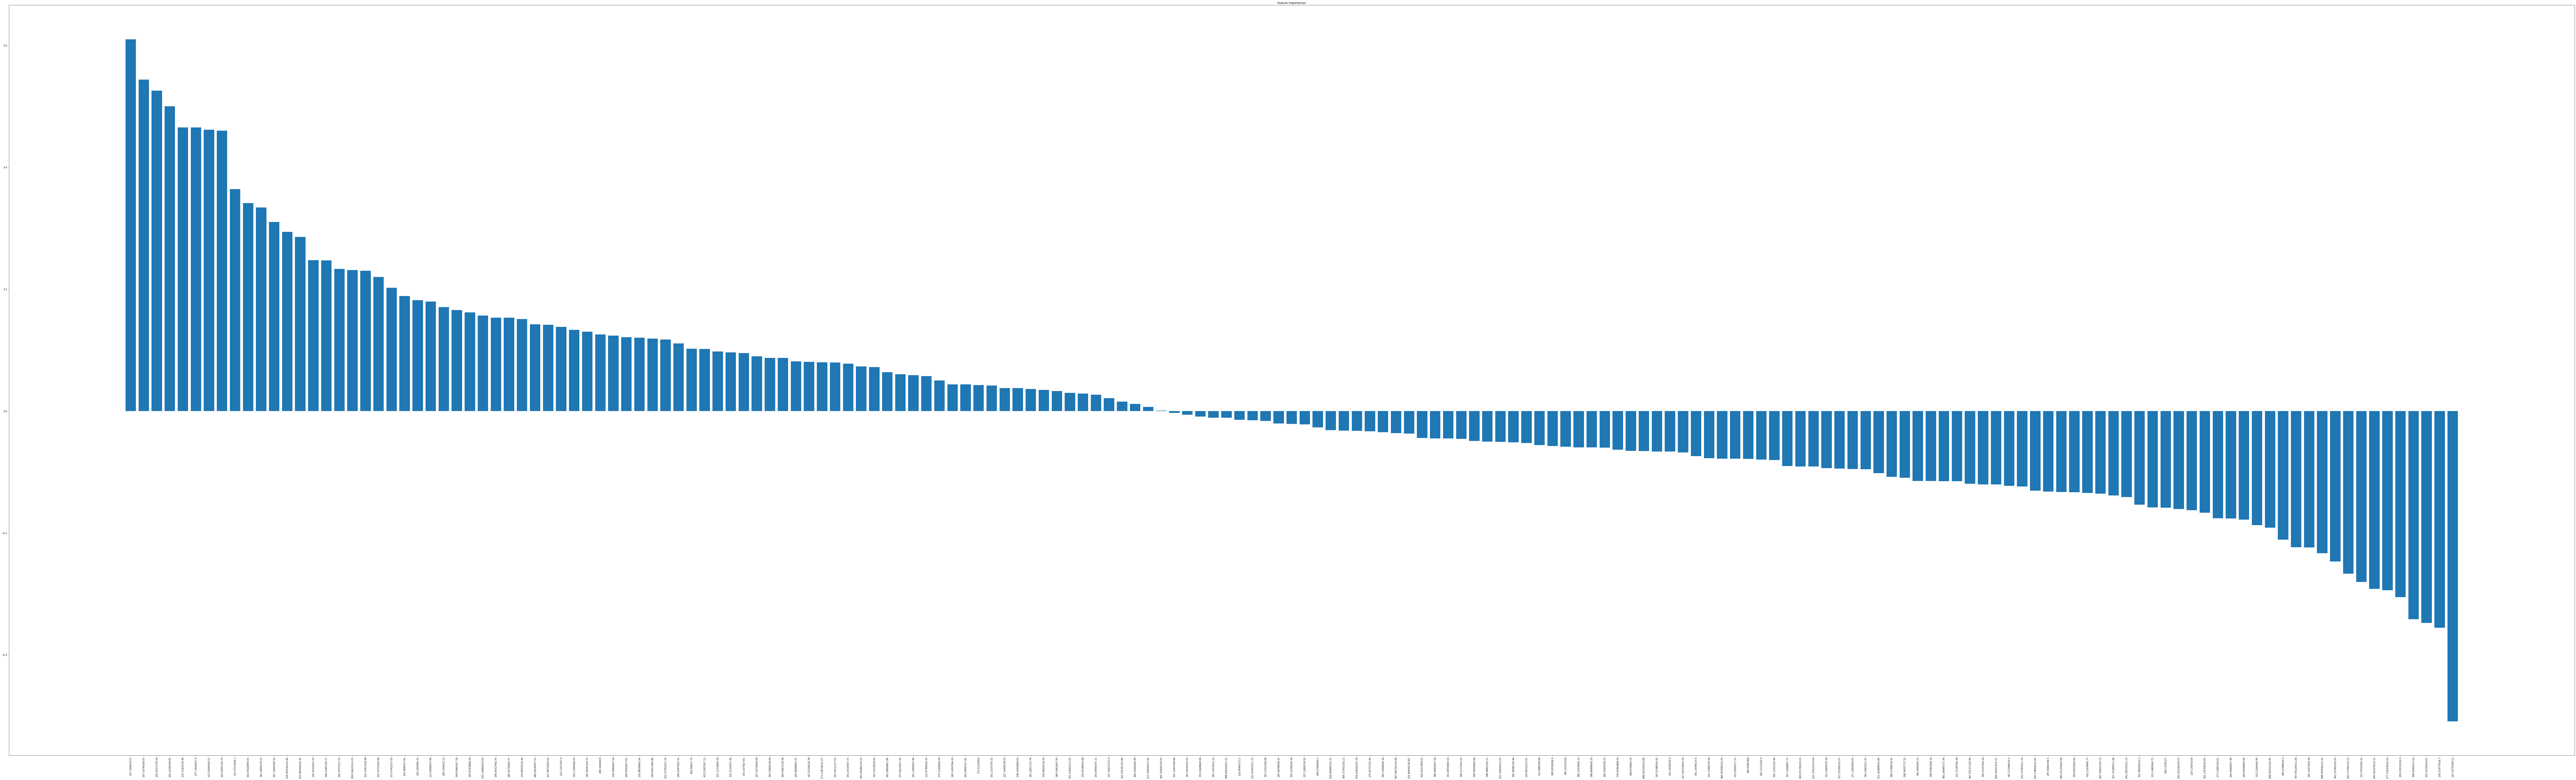

In [30]:
# Rank features by importance
sorted_feature_importance_pairs = sorted(feature_importance_pairs, reverse=True, key=lambda x: x[0])

# Extract feature names and importances
sorted_importances, _, sorted_feature_names = zip(*sorted_feature_importance_pairs)

# Convert feature importances to a numeric data type
sorted_importances = np.array(sorted_importances, dtype=float)

# Calculate the difference between subsequent feature importances
importance_diff = np.diff(sorted_importances)

# Find the index where the largest decrease occurs
largest_decrease_index = np.argmax(importance_diff)


# Store the top features and scores in a DataFrame
df_top_features = pd.DataFrame({'Feature': [], 'Score': []})

# Print the top features until the largest decrease
print("Top Features with Significant Importance:")
for i, (avg, std, name) in enumerate(sorted_feature_importance_pairs[:largest_decrease_index + 1], 1):
    try:
        avg_float = float(avg)
        print(f"{i}. Feature: {name}, Mean Score: {avg_float:.5f}, Standard Deviation: {std:.5f}")
        df_top_features = df_top_features.append({'Feature': name, 'Score': avg_float}, ignore_index=True)
    except ValueError:
        print(f"{i}. Feature: {name}, Mean Score: {avg}, Standard Deviation: {std} (non-numeric)")

# Save the df_top_features DataFrame to an Excel file
df_top_features.to_excel('top_features_scores_norm_LL.xlsx', index=False)

# Plot feature importance
plt.figure(figsize=(200, 60))
plt.bar(range(len(sorted_importances)), sorted_importances, tick_label=sorted_feature_names)
plt.xticks(rotation=90)
plt.title("Feature Importances")
# Save the figure as a PNG file
plt.savefig('feature_importances_plot_ORDERED_norm_LL.png', bbox_inches='tight')

# Show the plot (optional)
plt.show()

In [31]:
df = pd.DataFrame({'Importance Difference': importance_diff})
df.to_excel('importance_diff_norm_LL.xlsx', index=False)

In [32]:
class_names=np.array([0.0,1.0])

#Generating confusion matrices (for entire dataset; normalized BAs)
def evaluate_model(data_x, data_y):
    k_fold = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

    predicted_targets = np.array([])
    actual_targets = np.array([])

    for train_ix, test_ix in k_fold.split(data_x, data_y):
        train_x, train_y, test_x, test_y = data_x[train_ix], data_y[train_ix], data_x[test_ix], data_y[test_ix]

        # Fit the classifier
        model_cv = LogisticRegression(solver = 'newton-cg', C = 100, penalty = 'l2')
        classifier = model_cv.fit(train_x, train_y.ravel())

        # Predict the labels of the test set samples
        predicted_labels = classifier.predict(test_x)

        predicted_targets = np.append(predicted_targets, predicted_labels)
        actual_targets = np.append(actual_targets, test_y)

    return predicted_targets, actual_targets

In [33]:
def plot_confusion_matrix(predicted_labels_list, y_test_list):
    cnf_matrix = confusion_matrix(y_test_list, predicted_labels_list)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure()
    generate_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix, without normalization')
    plt.show()

    # Plot normalized confusion matrix
    plt.figure()
    generate_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, title='Normalized confusion matrix')
    plt.show()

In [34]:
def generate_confusion_matrix(cnf_matrix, classes, normalize=False, title='Confusion matrix'):
    if normalize:
        cnf_matrix = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cnf_matrix, interpolation='nearest', cmap=plt.get_cmap('Blues'))
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cnf_matrix.max() / 2.
    
    for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        plt.text(j, i, format(cnf_matrix[i, j], fmt), horizontalalignment="center",
                 color="white" if cnf_matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    return cnf_matrix

Confusion matrix, without normalization


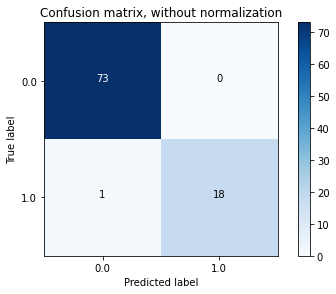

Normalized confusion matrix


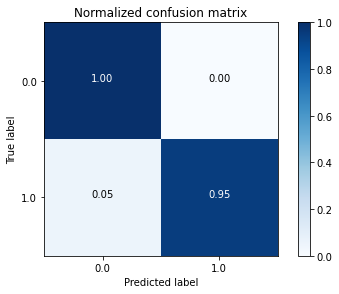

In [35]:
predicted_target, actual_target = evaluate_model(data_1, target_1)
plot_confusion_matrix(predicted_target, actual_target)

### For BL

In [36]:
data_rf = pd.read_csv(r'240905-NTA-Paper2-AnnotatedFeatures-ONLY-LogT-Input.csv', header=0) #Targets: 92 samples X 581 features
#del data_rf[data_rf.columns[0]] #Dropping sample information
#print(data_rf)

In [37]:
#Prompt user for source type of interest (GW, LF, BSL, WWTP, PP or PG)
preferred_type = input("Enter the source type of interest: ")

Enter the source type of interest: BL


In [38]:
#Manipulating data frame based on user input to make "Type" column read 1 for all samples of source of interest and 0 for all other samples
#Set up for binary classification (one-vs-all format)

# Define a function to apply to each row
def set_type(row):
    if row['Type'] == preferred_type:
        return 1
    else:
        return 0

# Create a new column "Type 2" with the updated values
data_rf['Type_2'] = data_rf.apply(set_type, axis=1)
del data_rf[data_rf.columns[0]] #Dropping original type column
#Reordering columns with Type_2 as first column
cols = list(data_rf.columns)
cols = [cols[-1]] + cols[:-1]
data_rf = data_rf[cols]

# Save the updated DataFrame to a new CSV file (if needed)
data_rf.to_csv('sample_data_with_labels_NEW10.csv', index=False)

In [39]:
#Changing pandas data frame to numpy for use in ML
data_rf_np = data_rf.to_numpy()
target_1 = data_rf_np[:,0].reshape(-1,1) #Convert target variables to 2D-array for sci-kit learn
data_1 = data_rf_np[:,1:]
#class_names=np.array([0.0,1.0])
#print(data_1.shape)
#print(data_1)

In [40]:
# Split into test and training, and evaluate optimal hyperparameters for Random Forest
totalR = 10
rs = np.arange(1, totalR + 1)

# Define hyperparameter grid for Logistic Regression
solver = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l1','l2']
C_val = [100, 10, 1.0, 0.1, 0.01]

grid = dict(solver=solver,penalty=penalty,C=C_val)

balanced_accuracy_scorer = make_scorer(balanced_accuracy_score)
# Initialize arrays to store results
test_balanced_accuracy = np.empty(len(rs))
train_balanced_accuracy = np.empty(len(rs))



for j in rs:
    X_train, X_test, y_train, y_test = train_test_split(
        data_1, target_1, test_size=0.2, stratify=target_1, random_state=j)
    
    # Create lr classifier
    rf = LogisticRegression()
    
    # Create repeated stratified k-fold cross-validator
    cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=5, random_state=42)
    
    # Perform hyperparameter tuning with GridSearchCV
    grid_search = GridSearchCV(estimator=rf, param_grid=grid, n_jobs=-1, cv=cv, scoring=balanced_accuracy_scorer, error_score=0)
    grid_result = grid_search.fit(X_train, y_train.ravel())
    
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

    # Get the best Logsistic regression model from GridSearchCV
    best_rf = grid_search.best_estimator_

    # Compute balanced accuracy on the training and test data
    train_predictions = best_rf.predict(X_train)
    test_predictions = best_rf.predict(X_test)
    
    train_ba = balanced_accuracy_score(y_train, train_predictions)
    test_ba = balanced_accuracy_score(y_test, test_predictions)
    
    train_balanced_accuracy[j-1] = train_ba
    test_balanced_accuracy[j-1] = test_ba

C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
150 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueErr

Best: 0.958333 using {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}


C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
150 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueErr

Best: 0.958333 using {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}


C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
150 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueErr

Best: 0.925000 using {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}


C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
150 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueErr

Best: 1.000000 using {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}


C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
150 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueErr

Best: 0.900000 using {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}


C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
150 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueErr

Best: 0.925000 using {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}


C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
150 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueErr

Best: 0.956746 using {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}


C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
150 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueErr

Best: 0.958333 using {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}


C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
150 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueErr

Best: 0.950000 using {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
Best: 0.966667 using {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}


C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
150 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueErr

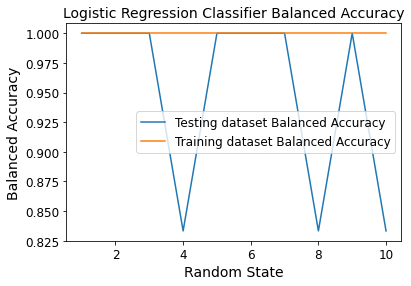

Best Testing Balanced Accuracy: 1.0
Corresponding Random State: 1


In [41]:
# Plot balanced accuracy for different random states
plt.plot(rs, test_balanced_accuracy, label='Testing dataset Balanced Accuracy')
plt.plot(rs, train_balanced_accuracy, label='Training dataset Balanced Accuracy')

plt.legend(fontsize=12)
plt.title('Logistic Regression Classifier Balanced Accuracy', fontsize=14)
plt.xlabel('Random State', fontsize=14)
plt.ylabel('Balanced Accuracy', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig('lR-Tuning-NORM-BL.png', dpi=150, bbox_inches='tight')
plt.show()

# Print the value of best balanced accuracy and the corresponding random state
best_test_balanced_accuracy = np.max(test_balanced_accuracy)
best_random_state = rs[np.argmax(test_balanced_accuracy)]
print("Best Testing Balanced Accuracy:", best_test_balanced_accuracy)
print("Corresponding Random State:", best_random_state)

In [42]:
print(train_balanced_accuracy)
print(test_balanced_accuracy)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1.   1.   1.   0.83 1.   1.   1.   0.83 1.   0.83]


Feature: 0, Score: 0.89972
Feature: 1, Score: -0.25465
Feature: 2, Score: -0.03237
Feature: 3, Score: 0.05478
Feature: 4, Score: -0.28109
Feature: 5, Score: 0.37749
Feature: 6, Score: 0.10783
Feature: 7, Score: 0.02792
Feature: 8, Score: 0.89878
Feature: 9, Score: -0.52875
Feature: 10, Score: -0.37433
Feature: 11, Score: 0.02190
Feature: 12, Score: 0.20972
Feature: 13, Score: 0.41920
Feature: 14, Score: -0.31297
Feature: 15, Score: -0.29387
Feature: 16, Score: -0.12150
Feature: 17, Score: 0.09045
Feature: 18, Score: 0.31858
Feature: 19, Score: -0.14400
Feature: 20, Score: -0.09825
Feature: 21, Score: -0.09536
Feature: 22, Score: -0.20045
Feature: 23, Score: -0.05853
Feature: 24, Score: -0.29204
Feature: 25, Score: -0.35705
Feature: 26, Score: -0.20013
Feature: 27, Score: 0.14521
Feature: 28, Score: -0.04288
Feature: 29, Score: -0.35032
Feature: 30, Score: -0.02945
Feature: 31, Score: -0.01940
Feature: 32, Score: -0.13144
Feature: 33, Score: 0.50700
Feature: 34, Score: -0.07102
Feature:

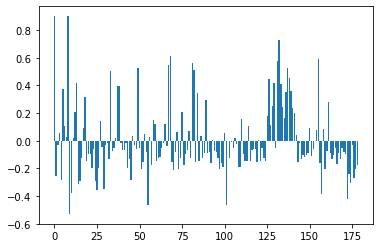

In [43]:
#Now running optimized model over the entire dataset
model = LogisticRegression(solver = 'newton-cg', C = 100, penalty = 'l2')
# fit the model
model.fit(data_1, target_1.ravel())

# get importance
importance = model.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

Feature 0: Average Score: 0.89972, Standard Deviation: 0.00000
Feature 1: Average Score: -0.25465, Standard Deviation: 0.00000
Feature 2: Average Score: -0.03237, Standard Deviation: 0.00000
Feature 3: Average Score: 0.05478, Standard Deviation: 0.00000
Feature 4: Average Score: -0.28109, Standard Deviation: 0.00000
Feature 5: Average Score: 0.37749, Standard Deviation: 0.00000
Feature 6: Average Score: 0.10783, Standard Deviation: 0.00000
Feature 7: Average Score: 0.02792, Standard Deviation: 0.00000
Feature 8: Average Score: 0.89878, Standard Deviation: 0.00000
Feature 9: Average Score: -0.52875, Standard Deviation: 0.00000
Feature 10: Average Score: -0.37433, Standard Deviation: 0.00000
Feature 11: Average Score: 0.02190, Standard Deviation: 0.00000
Feature 12: Average Score: 0.20972, Standard Deviation: 0.00000
Feature 13: Average Score: 0.41920, Standard Deviation: 0.00000
Feature 14: Average Score: -0.31297, Standard Deviation: 0.00000
Feature 15: Average Score: -0.29387, Standar

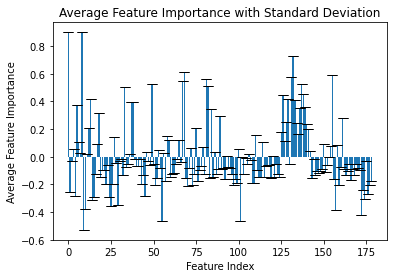

In [44]:
# Initialize variables to store feature importances across iterations
all_importances = []

# Number of iterations
num_iterations = 100

for iteration in range(num_iterations):
    # Create and fit the model
    model = LogisticRegression(solver = 'newton-cg', C = 100, penalty = 'l2')
    model.fit(data_1, target_1.ravel())

    # Get importance and store in the list
    importance = model.coef_[0]
    all_importances.append(importance)

# Convert the list to a NumPy array for easy calculations
all_importances = np.array(all_importances)

# Calculate average and standard deviation of feature importances
average_importance = np.mean(all_importances, axis=0)
std_importance = np.std(all_importances, axis=0)

# Summarize and print feature importance statistics
for i, (avg_score, std_score) in enumerate(zip(average_importance, std_importance)):
    print(f'Feature {i}: Average Score: {avg_score:.5f}, Standard Deviation: {std_score:.5f}')

# Plot the average feature importance
plt.bar([x for x in range(len(average_importance))], average_importance, yerr=std_importance, capsize=5)
plt.xlabel('Feature Index')
plt.ylabel('Average Feature Importance')
plt.title('Average Feature Importance with Standard Deviation')
plt.show()

In [45]:
labels_dat = pd.read_csv("240905-NTA-Paper2-AnnotatedFeatures-ONLY-Labels.csv")
feature_names = labels_dat.columns

feature_importance_pairs = [(avg, std, name) for avg, std, name in zip(average_importance, std_importance, feature_names)]

# Sort the list by average importance in descending order
feature_importance_pairs.sort(reverse=True, key=lambda x: x[0])

# Print the output for the top 10 features
print("Top 10 Features:")
for avg, std, name in feature_importance_pairs[:10]:
    print(f'Feature: {name}, Mean Score: {avg:.5f}, Standard Deviation: {std:.5f}')

Top 10 Features:
Feature: 498.92902/11.61, Mean Score: 0.89972, Standard Deviation: 0.00000
Feature: 412.965695/10.3, Mean Score: 0.89878, Standard Deviation: 0.00000
Feature: 295.263376/19.32, Mean Score: 0.73066, Standard Deviation: 0.00000
Feature: 165.040553/7.45, Mean Score: 0.61084, Standard Deviation: 0.00000
Feature: 361.237403/16.43, Mean Score: 0.59272, Standard Deviation: 0.00000
Feature: 367.212948/10.5, Mean Score: 0.57598, Standard Deviation: 0.00000
Feature: 251.164574/8.66, Mean Score: 0.56336, Standard Deviation: 0.00000
Feature: 239.059145/10.46, Mean Score: 0.54981, Standard Deviation: 0.00000
Feature: 144.045178/6.98, Mean Score: 0.52883, Standard Deviation: 0.00000
Feature: 265.143735/9.39, Mean Score: 0.52438, Standard Deviation: 0.00000


In [46]:
labels_dat = pd.read_csv("240905-NTA-Paper2-AnnotatedFeatures-ONLY-Labels.csv")
feature_names = labels_dat.columns

# Get indices of the top 10 features based on mean importance
top_10_indices = np.argsort(average_importance)[::-1][:10]

# Print top 10 features along with their average and standard deviation
print("Top 10 Features:")
for i in top_10_indices:
    print(f'Feature: {feature_names[i]}, Mean Score: {average_importance[i]:.5f}, Standard Deviation: {std_importance[i]:.5f}')

Top 10 Features:
Feature: 498.92902/11.61, Mean Score: 0.89972, Standard Deviation: 0.00000
Feature: 412.965695/10.3, Mean Score: 0.89878, Standard Deviation: 0.00000
Feature: 295.263376/19.32, Mean Score: 0.73066, Standard Deviation: 0.00000
Feature: 165.040553/7.45, Mean Score: 0.61084, Standard Deviation: 0.00000
Feature: 361.237403/16.43, Mean Score: 0.59272, Standard Deviation: 0.00000
Feature: 367.212948/10.5, Mean Score: 0.57598, Standard Deviation: 0.00000
Feature: 251.164574/8.66, Mean Score: 0.56336, Standard Deviation: 0.00000
Feature: 239.059145/10.46, Mean Score: 0.54981, Standard Deviation: 0.00000
Feature: 144.045178/6.98, Mean Score: 0.52883, Standard Deviation: 0.00000
Feature: 265.143735/9.39, Mean Score: 0.52438, Standard Deviation: 0.00000


Top Features with Significant Importance:
1. Feature: 498.92902/11.61, Mean Score: 0.89972, Standard Deviation: 0.00000
2. Feature: 412.965695/10.3, Mean Score: 0.89878, Standard Deviation: 0.00000
3. Feature: 295.263376/19.32, Mean Score: 0.73066, Standard Deviation: 0.00000
4. Feature: 165.040553/7.45, Mean Score: 0.61084, Standard Deviation: 0.00000
5. Feature: 361.237403/16.43, Mean Score: 0.59272, Standard Deviation: 0.00000
6. Feature: 367.212948/10.5, Mean Score: 0.57598, Standard Deviation: 0.00000
7. Feature: 251.164574/8.66, Mean Score: 0.56336, Standard Deviation: 0.00000
8. Feature: 239.059145/10.46, Mean Score: 0.54981, Standard Deviation: 0.00000
9. Feature: 144.045178/6.98, Mean Score: 0.52883, Standard Deviation: 0.00000
10. Feature: 265.143735/9.39, Mean Score: 0.52438, Standard Deviation: 0.00000
11. Feature: 333.206086/8.06, Mean Score: 0.50775, Standard Deviation: 0.00000
12. Feature: 254.219779/16.7, Mean Score: 0.50700, Standard Deviation: 0.00000
13. Feature: 383

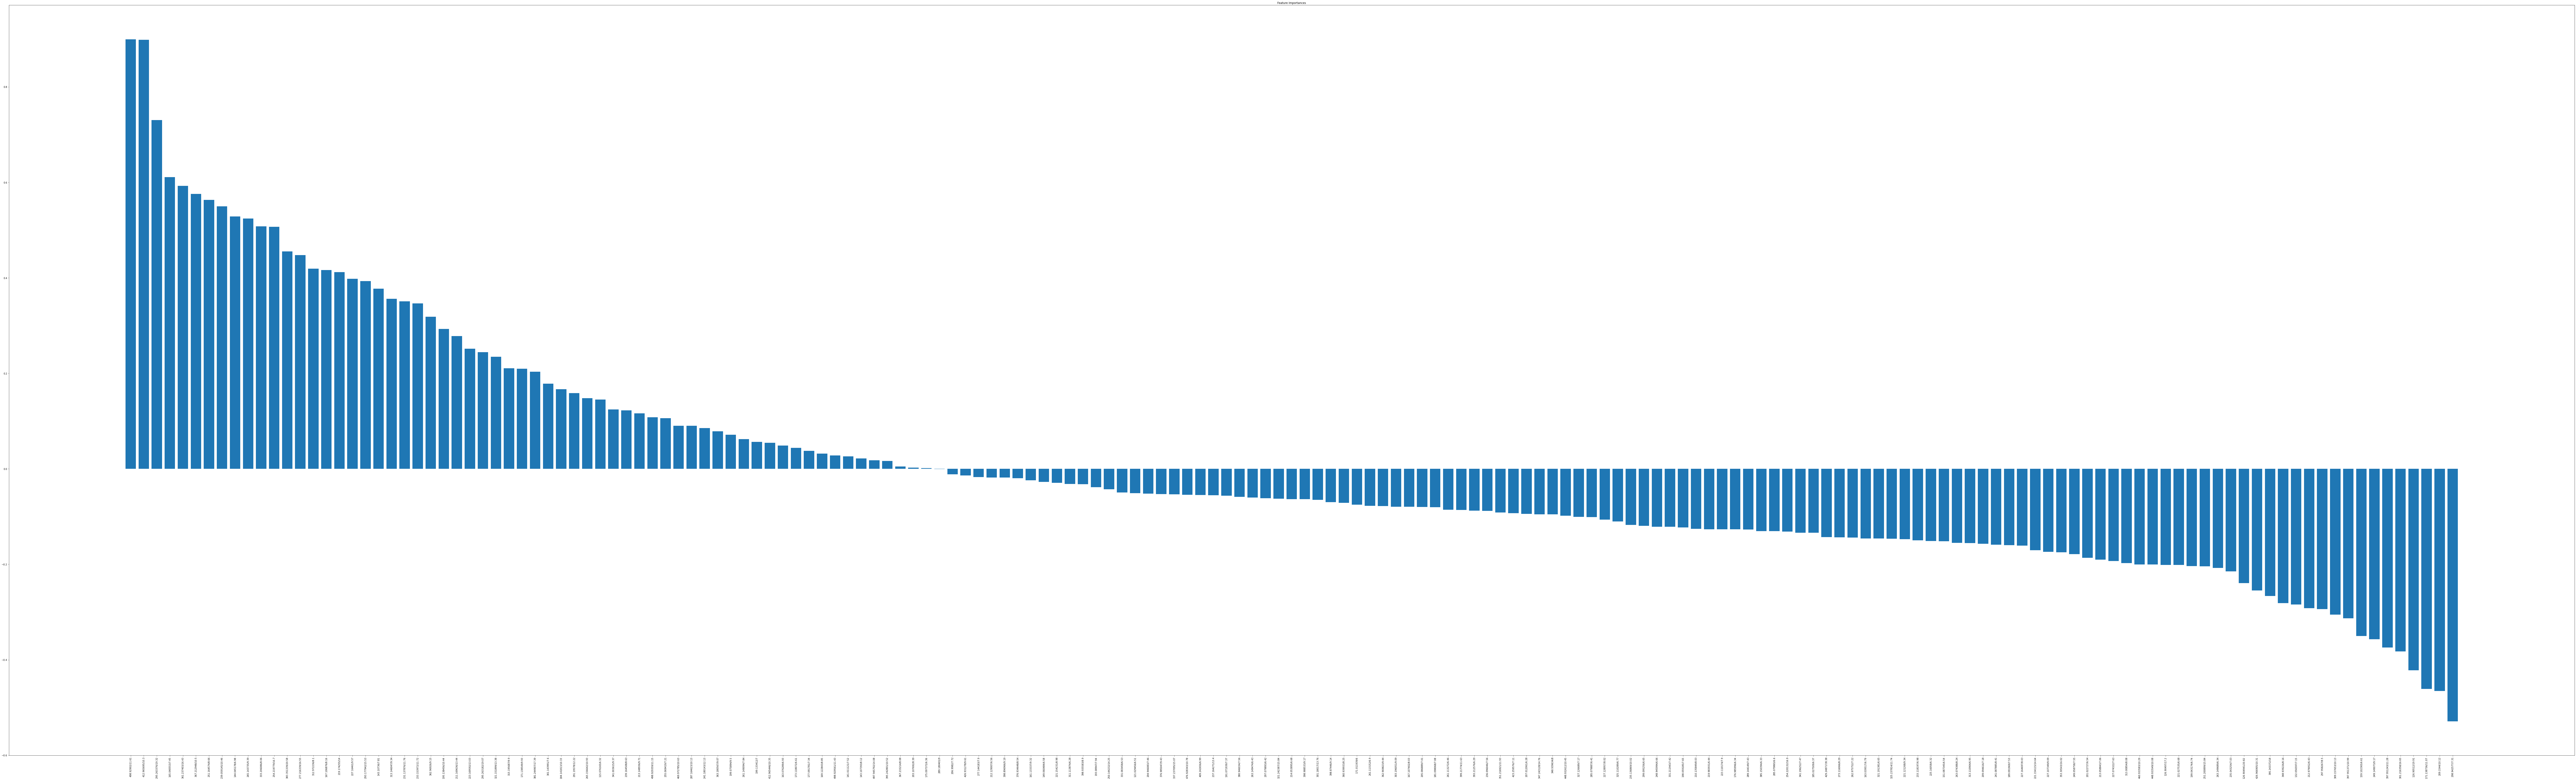

In [47]:
# Rank features by importance
sorted_feature_importance_pairs = sorted(feature_importance_pairs, reverse=True, key=lambda x: x[0])

# Extract feature names and importances
sorted_importances, _, sorted_feature_names = zip(*sorted_feature_importance_pairs)

# Convert feature importances to a numeric data type
sorted_importances = np.array(sorted_importances, dtype=float)

# Calculate the difference between subsequent feature importances
importance_diff = np.diff(sorted_importances)

# Find the index where the largest decrease occurs
largest_decrease_index = np.argmax(importance_diff)


# Store the top features and scores in a DataFrame
df_top_features = pd.DataFrame({'Feature': [], 'Score': []})

# Print the top features until the largest decrease
print("Top Features with Significant Importance:")
for i, (avg, std, name) in enumerate(sorted_feature_importance_pairs[:largest_decrease_index + 1], 1):
    try:
        avg_float = float(avg)
        print(f"{i}. Feature: {name}, Mean Score: {avg_float:.5f}, Standard Deviation: {std:.5f}")
        df_top_features = df_top_features.append({'Feature': name, 'Score': avg_float}, ignore_index=True)
    except ValueError:
        print(f"{i}. Feature: {name}, Mean Score: {avg}, Standard Deviation: {std} (non-numeric)")

# Save the df_top_features DataFrame to an Excel file
df_top_features.to_excel('top_features_scores_norm_BL.xlsx', index=False)

# Plot feature importance
plt.figure(figsize=(200, 60))
plt.bar(range(len(sorted_importances)), sorted_importances, tick_label=sorted_feature_names)
plt.xticks(rotation=90)
plt.title("Feature Importances")
# Save the figure as a PNG file
plt.savefig('feature_importances_plot_ORDERED_norm_BL.png', bbox_inches='tight')

# Show the plot (optional)
plt.show()

In [48]:
df = pd.DataFrame({'Importance Difference': importance_diff})
df.to_excel('importance_diff_BL.xlsx', index=False)

In [49]:
class_names=np.array([0.0,1.0])

#Generating confusion matrices (for entire dataset; normalized BAs)
def evaluate_model(data_x, data_y):
    k_fold = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

    predicted_targets = np.array([])
    actual_targets = np.array([])

    for train_ix, test_ix in k_fold.split(data_x, data_y):
        train_x, train_y, test_x, test_y = data_x[train_ix], data_y[train_ix], data_x[test_ix], data_y[test_ix]

        # Fit the classifier
        model_cv = LogisticRegression(solver = 'newton-cg', C = 100, penalty = 'l2')
        classifier = model_cv.fit(train_x, train_y.ravel())

        # Predict the labels of the test set samples
        predicted_labels = classifier.predict(test_x)

        predicted_targets = np.append(predicted_targets, predicted_labels)
        actual_targets = np.append(actual_targets, test_y)

    return predicted_targets, actual_targets

In [50]:
def plot_confusion_matrix(predicted_labels_list, y_test_list):
    cnf_matrix = confusion_matrix(y_test_list, predicted_labels_list)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure()
    generate_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix, without normalization')
    plt.show()

    # Plot normalized confusion matrix
    plt.figure()
    generate_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, title='Normalized confusion matrix')
    plt.show()

In [51]:
def generate_confusion_matrix(cnf_matrix, classes, normalize=False, title='Confusion matrix'):
    if normalize:
        cnf_matrix = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cnf_matrix, interpolation='nearest', cmap=plt.get_cmap('Blues'))
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cnf_matrix.max() / 2.
    
    for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        plt.text(j, i, format(cnf_matrix[i, j], fmt), horizontalalignment="center",
                 color="white" if cnf_matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    return cnf_matrix

Confusion matrix, without normalization


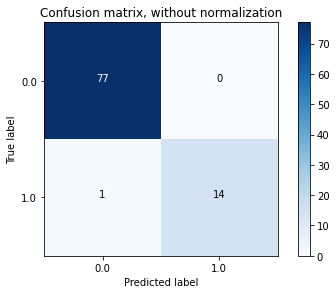

Normalized confusion matrix


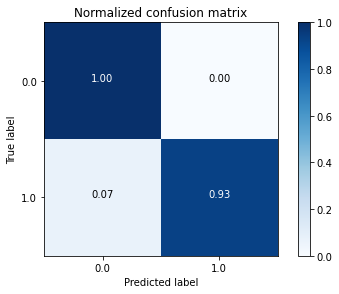

In [52]:
predicted_target, actual_target = evaluate_model(data_1, target_1)
plot_confusion_matrix(predicted_target, actual_target)

### WWTP

In [53]:
data_rf = pd.read_csv(r'240905-NTA-Paper2-AnnotatedFeatures-ONLY-LogT-Input.csv', header=0) #Targets: 92 samples X 581 features
#del data_rf[data_rf.columns[0]] #Dropping sample information
#print(data_rf)

In [54]:
#Prompt user for source type of interest (GW, LF, BSL, WWTP, PP or PG)
preferred_type = input("Enter the source type of interest: ")

Enter the source type of interest: WWTP


In [55]:
#Manipulating data frame based on user input to make "Type" column read 1 for all samples of source of interest and 0 for all other samples
#Set up for binary classification (one-vs-all format)

# Define a function to apply to each row
def set_type(row):
    if row['Type'] == preferred_type:
        return 1
    else:
        return 0

# Create a new column "Type 2" with the updated values
data_rf['Type_2'] = data_rf.apply(set_type, axis=1)
del data_rf[data_rf.columns[0]] #Dropping original type column
#Reordering columns with Type_2 as first column
cols = list(data_rf.columns)
cols = [cols[-1]] + cols[:-1]
data_rf = data_rf[cols]

# Save the updated DataFrame to a new CSV file (if needed)
data_rf.to_csv('sample_data_with_labels_NEW10.csv', index=False)

In [56]:
#Changing pandas data frame to numpy for use in ML
data_rf_np = data_rf.to_numpy()
target_1 = data_rf_np[:,0].reshape(-1,1) #Convert target variables to 2D-array for sci-kit learn
data_1 = data_rf_np[:,1:]
#class_names=np.array([0.0,1.0])
#print(data_1.shape)
#print(data_1)

In [57]:
# Split into test and training, and evaluate optimal hyperparameters for Random Forest
totalR = 10
rs = np.arange(1, totalR + 1)

# Define hyperparameter grid for Logistic Regression
solver = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l1','l2']
C_val = [100, 10, 1.0, 0.1, 0.01]

grid = dict(solver=solver,penalty=penalty,C=C_val)

balanced_accuracy_scorer = make_scorer(balanced_accuracy_score)
# Initialize arrays to store results
test_balanced_accuracy = np.empty(len(rs))
train_balanced_accuracy = np.empty(len(rs))



for j in rs:
    X_train, X_test, y_train, y_test = train_test_split(
        data_1, target_1, test_size=0.2, stratify=target_1, random_state=j)
    
    # Create Random Forest classifier
    rf = LogisticRegression()
    
    # Create repeated stratified k-fold cross-validator
    cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=5, random_state=42)
    
    # Perform hyperparameter tuning with GridSearchCV
    grid_search = GridSearchCV(estimator=rf, param_grid=grid, n_jobs=-1, cv=cv, scoring=balanced_accuracy_scorer, error_score=0)
    grid_result = grid_search.fit(X_train, y_train.ravel())
    
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

    # Get the best Logsistic regression model from GridSearchCV
    best_rf = grid_search.best_estimator_

    # Compute balanced accuracy on the training and test data
    train_predictions = best_rf.predict(X_train)
    test_predictions = best_rf.predict(X_test)
    
    train_ba = balanced_accuracy_score(y_train, train_predictions)
    test_ba = balanced_accuracy_score(y_test, test_predictions)
    
    train_balanced_accuracy[j-1] = train_ba
    test_balanced_accuracy[j-1] = test_ba

C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
150 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueErr

Best: 0.949474 using {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}


C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
150 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueErr

Best: 0.963158 using {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}


C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
150 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueErr

Best: 0.986667 using {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}


C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
150 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueErr

Best: 0.943158 using {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}


C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
150 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueErr

Best: 0.976228 using {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}


C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
150 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueErr

Best: 0.961404 using {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}


C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
150 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueErr

Best: 0.956491 using {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}


C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
150 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueErr

Best: 0.957982 using {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}


C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
150 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueErr

Best: 0.948158 using {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
Best: 0.981053 using {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}


C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
150 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueErr

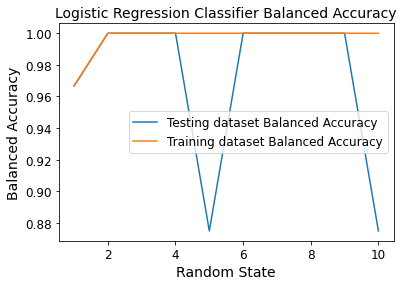

Best Testing Balanced Accuracy: 1.0
Corresponding Random State: 2


In [58]:
# Plot balanced accuracy for different random states
plt.plot(rs, test_balanced_accuracy, label='Testing dataset Balanced Accuracy')
plt.plot(rs, train_balanced_accuracy, label='Training dataset Balanced Accuracy')

plt.legend(fontsize=12)
plt.title('Logistic Regression Classifier Balanced Accuracy', fontsize=14)
plt.xlabel('Random State', fontsize=14)
plt.ylabel('Balanced Accuracy', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig('lR-Tuning-NORM-WWTP.png', dpi=150, bbox_inches='tight')
plt.show()

# Print the value of best balanced accuracy and the corresponding random state
best_test_balanced_accuracy = np.max(test_balanced_accuracy)
best_random_state = rs[np.argmax(test_balanced_accuracy)]
print("Best Testing Balanced Accuracy:", best_test_balanced_accuracy)
print("Corresponding Random State:", best_random_state)

In [59]:
print(train_balanced_accuracy)
print(test_balanced_accuracy)

[0.97 1.   1.   1.   1.   1.   1.   1.   1.   1.  ]
[0.97 1.   1.   1.   0.88 1.   1.   1.   1.   0.88]


Feature: 0, Score: -0.14332
Feature: 1, Score: -0.18565
Feature: 2, Score: -0.29090
Feature: 3, Score: -0.13036
Feature: 4, Score: -0.07198
Feature: 5, Score: -0.31194
Feature: 6, Score: -0.04802
Feature: 7, Score: -0.12369
Feature: 8, Score: -0.74321
Feature: 9, Score: -0.25930
Feature: 10, Score: -0.25920
Feature: 11, Score: -0.60986
Feature: 12, Score: -0.23136
Feature: 13, Score: -0.49730
Feature: 14, Score: -0.15480
Feature: 15, Score: -0.00438
Feature: 16, Score: 0.01488
Feature: 17, Score: 0.01541
Feature: 18, Score: -0.30804
Feature: 19, Score: -0.39477
Feature: 20, Score: -0.25945
Feature: 21, Score: 0.01583
Feature: 22, Score: 0.00640
Feature: 23, Score: 0.01563
Feature: 24, Score: -0.00547
Feature: 25, Score: 0.40513
Feature: 26, Score: -0.14667
Feature: 27, Score: 0.14576
Feature: 28, Score: -0.33314
Feature: 29, Score: 0.64604
Feature: 30, Score: -0.63786
Feature: 31, Score: 0.01562
Feature: 32, Score: -0.56634
Feature: 33, Score: -0.15763
Feature: 34, Score: 0.01558
Featu

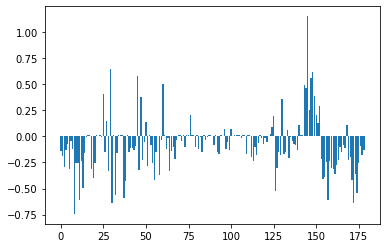

In [60]:
#Now running optimized model over the entire dataset
model = LogisticRegression(solver = 'newton-cg', C = 100, penalty = 'l2')
# fit the model
model.fit(data_1, target_1.ravel())

# get importance
importance = model.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

Feature 0: Average Score: -0.14332, Standard Deviation: 0.00000
Feature 1: Average Score: -0.18565, Standard Deviation: 0.00000
Feature 2: Average Score: -0.29090, Standard Deviation: 0.00000
Feature 3: Average Score: -0.13036, Standard Deviation: 0.00000
Feature 4: Average Score: -0.07198, Standard Deviation: 0.00000
Feature 5: Average Score: -0.31194, Standard Deviation: 0.00000
Feature 6: Average Score: -0.04802, Standard Deviation: 0.00000
Feature 7: Average Score: -0.12369, Standard Deviation: 0.00000
Feature 8: Average Score: -0.74321, Standard Deviation: 0.00000
Feature 9: Average Score: -0.25930, Standard Deviation: 0.00000
Feature 10: Average Score: -0.25920, Standard Deviation: 0.00000
Feature 11: Average Score: -0.60986, Standard Deviation: 0.00000
Feature 12: Average Score: -0.23136, Standard Deviation: 0.00000
Feature 13: Average Score: -0.49730, Standard Deviation: 0.00000
Feature 14: Average Score: -0.15480, Standard Deviation: 0.00000
Feature 15: Average Score: -0.00438

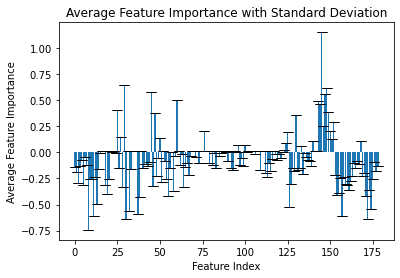

In [61]:
# Initialize variables to store feature importances across iterations
all_importances = []

# Number of iterations
num_iterations = 100

for iteration in range(num_iterations):
    # Create and fit the model
    model = LogisticRegression(solver = 'newton-cg', C = 100, penalty = 'l2')
    model.fit(data_1, target_1.ravel())

    # Get importance and store in the list
    importance = model.coef_[0]
    all_importances.append(importance)

# Convert the list to a NumPy array for easy calculations
all_importances = np.array(all_importances)

# Calculate average and standard deviation of feature importances
average_importance = np.mean(all_importances, axis=0)
std_importance = np.std(all_importances, axis=0)

# Summarize and print feature importance statistics
for i, (avg_score, std_score) in enumerate(zip(average_importance, std_importance)):
    print(f'Feature {i}: Average Score: {avg_score:.5f}, Standard Deviation: {std_score:.5f}')

# Plot the average feature importance
plt.bar([x for x in range(len(average_importance))], average_importance, yerr=std_importance, capsize=5)
plt.xlabel('Feature Index')
plt.ylabel('Average Feature Importance')
plt.title('Average Feature Importance with Standard Deviation')
plt.show()

In [62]:
labels_dat = pd.read_csv("240905-NTA-Paper2-AnnotatedFeatures-ONLY-Labels.csv")
feature_names = labels_dat.columns

feature_importance_pairs = [(avg, std, name) for avg, std, name in zip(average_importance, std_importance, feature_names)]

# Sort the list by average importance in descending order
feature_importance_pairs.sort(reverse=True, key=lambda x: x[0])

# Print the output for the top 10 features
print("Top 10 Features:")
for avg, std, name in feature_importance_pairs[:10]:
    print(f'Feature: {name}, Mean Score: {avg:.5f}, Standard Deviation: {std:.5f}')

Top 10 Features:
Feature: 285.079865/6.6, Mean Score: 1.15296, Standard Deviation: 0.00000
Feature: 159.102365/6.61, Mean Score: 0.64604, Standard Deviation: 0.00000
Feature: 285.079887/6.41, Mean Score: 0.61648, Standard Deviation: 0.00000
Feature: 132.056597/7.15, Mean Score: 0.58269, Standard Deviation: 0.00000
Feature: 299.095256/6.65, Mean Score: 0.56044, Standard Deviation: 0.00000
Feature: 321.191381/6.65, Mean Score: 0.49861, Standard Deviation: 0.00000
Feature: 313.110904/6.95, Mean Score: 0.49148, Standard Deviation: 0.00000
Feature: 212.129007/6.56, Mean Score: 0.46300, Standard Deviation: 0.00000
Feature: 249.149073/9.17, Mean Score: 0.40513, Standard Deviation: 0.00000
Feature: 393.212576/6.29, Mean Score: 0.38591, Standard Deviation: 0.00000


In [63]:
labels_dat = pd.read_csv("240905-NTA-Paper2-AnnotatedFeatures-ONLY-Labels.csv")
feature_names = labels_dat.columns

# Get indices of the top 10 features based on mean importance
top_10_indices = np.argsort(average_importance)[::-1][:10]

# Print top 10 features along with their average and standard deviation
print("Top 10 Features:")
for i in top_10_indices:
    print(f'Feature: {feature_names[i]}, Mean Score: {average_importance[i]:.5f}, Standard Deviation: {std_importance[i]:.5f}')

Top 10 Features:
Feature: 285.079865/6.6, Mean Score: 1.15296, Standard Deviation: 0.00000
Feature: 159.102365/6.61, Mean Score: 0.64604, Standard Deviation: 0.00000
Feature: 285.079887/6.41, Mean Score: 0.61648, Standard Deviation: 0.00000
Feature: 132.056597/7.15, Mean Score: 0.58269, Standard Deviation: 0.00000
Feature: 299.095256/6.65, Mean Score: 0.56044, Standard Deviation: 0.00000
Feature: 321.191381/6.65, Mean Score: 0.49861, Standard Deviation: 0.00000
Feature: 313.110904/6.95, Mean Score: 0.49148, Standard Deviation: 0.00000
Feature: 212.129007/6.56, Mean Score: 0.46300, Standard Deviation: 0.00000
Feature: 249.149073/9.17, Mean Score: 0.40513, Standard Deviation: 0.00000
Feature: 393.212576/6.29, Mean Score: 0.38591, Standard Deviation: 0.00000


Top Features with Significant Importance:
1. Feature: 285.079865/6.6, Mean Score: 1.15296, Standard Deviation: 0.00000
2. Feature: 159.102365/6.61, Mean Score: 0.64604, Standard Deviation: 0.00000
3. Feature: 285.079887/6.41, Mean Score: 0.61648, Standard Deviation: 0.00000
4. Feature: 132.056597/7.15, Mean Score: 0.58269, Standard Deviation: 0.00000
5. Feature: 299.095256/6.65, Mean Score: 0.56044, Standard Deviation: 0.00000
6. Feature: 321.191381/6.65, Mean Score: 0.49861, Standard Deviation: 0.00000
7. Feature: 313.110904/6.95, Mean Score: 0.49148, Standard Deviation: 0.00000
8. Feature: 212.129007/6.56, Mean Score: 0.46300, Standard Deviation: 0.00000
9. Feature: 249.149073/9.17, Mean Score: 0.40513, Standard Deviation: 0.00000
10. Feature: 393.212576/6.29, Mean Score: 0.38591, Standard Deviation: 0.00000
11. Feature: 149.060484/6.58, Mean Score: 0.37357, Standard Deviation: 0.00000
12. Feature: 204.946083/7.46, Mean Score: 0.35518, Standard Deviation: 0.00000
13. Feature: 297.079

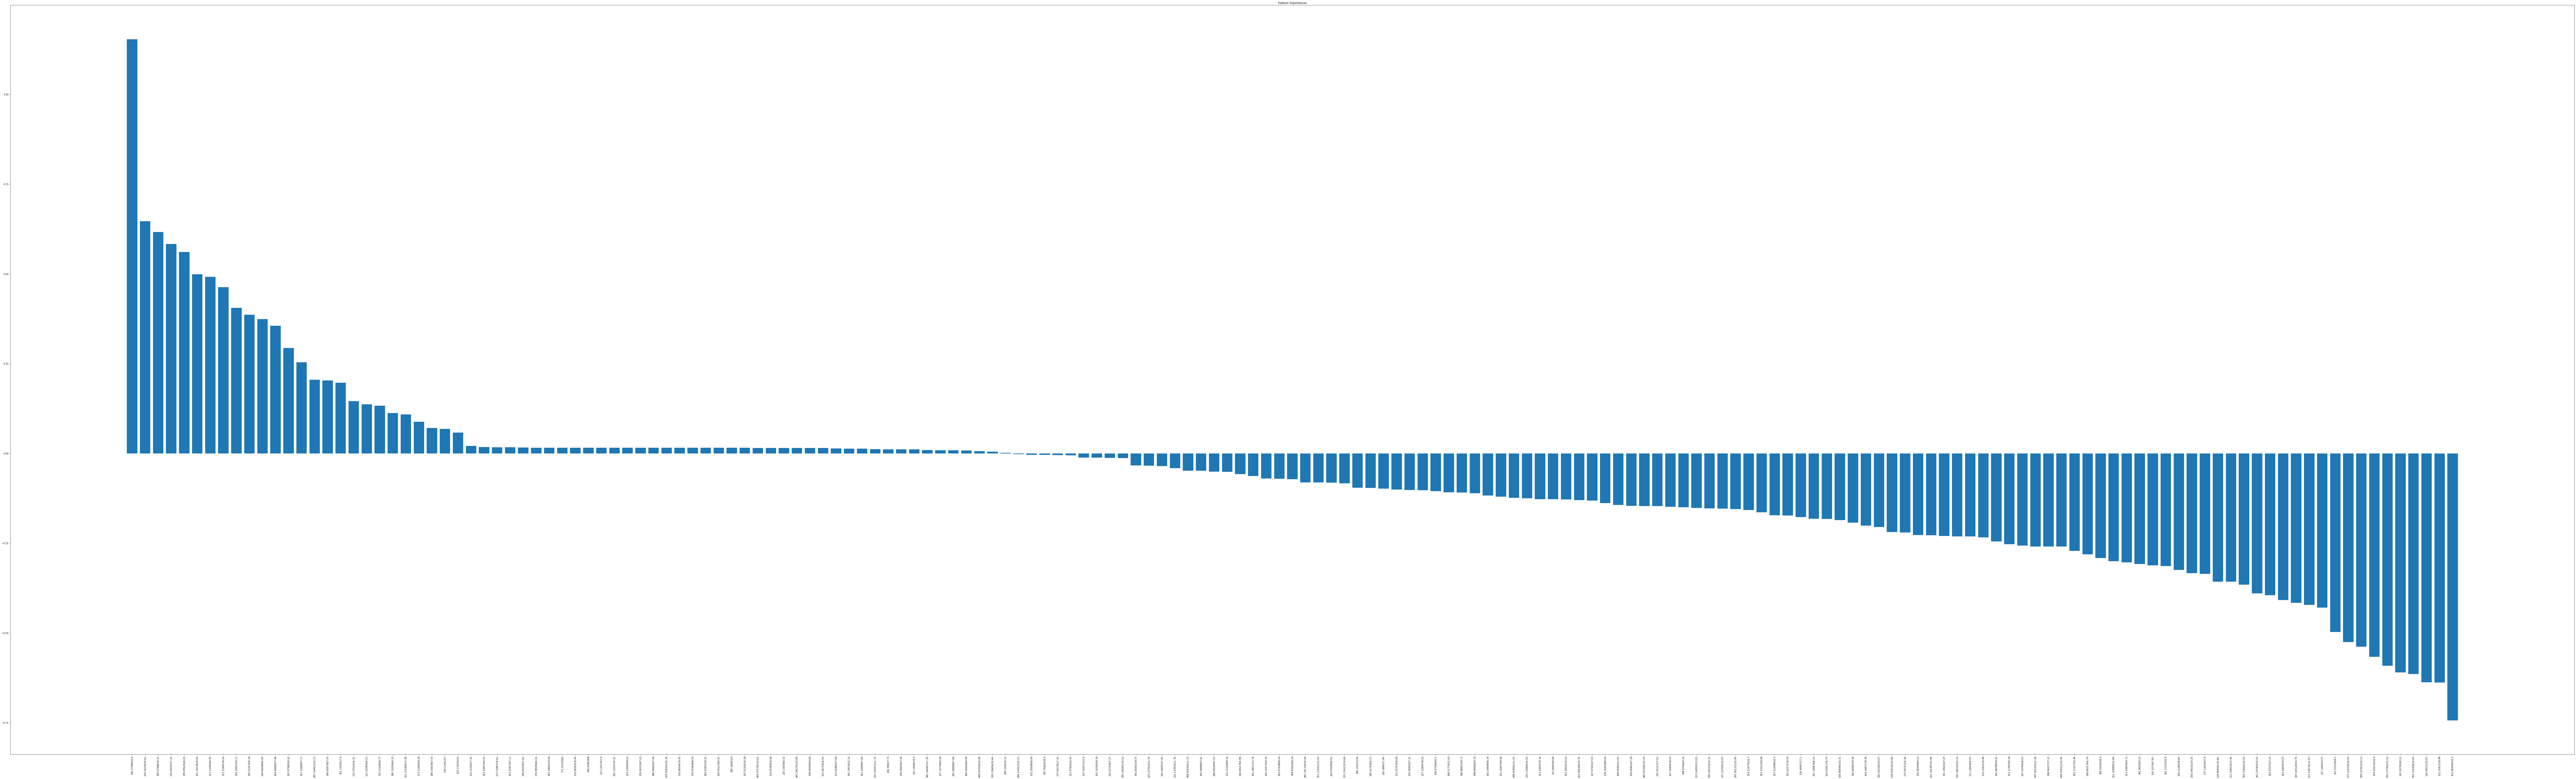

In [64]:
# Rank features by importance
sorted_feature_importance_pairs = sorted(feature_importance_pairs, reverse=True, key=lambda x: x[0])

# Extract feature names and importances
sorted_importances, _, sorted_feature_names = zip(*sorted_feature_importance_pairs)

# Convert feature importances to a numeric data type
sorted_importances = np.array(sorted_importances, dtype=float)

# Calculate the difference between subsequent feature importances
importance_diff = np.diff(sorted_importances)

# Find the index where the largest decrease occurs
largest_decrease_index = np.argmax(importance_diff)


# Store the top features and scores in a DataFrame
df_top_features = pd.DataFrame({'Feature': [], 'Score': []})

# Print the top features until the largest decrease
print("Top Features with Significant Importance:")
for i, (avg, std, name) in enumerate(sorted_feature_importance_pairs[:largest_decrease_index + 1], 1):
    try:
        avg_float = float(avg)
        print(f"{i}. Feature: {name}, Mean Score: {avg_float:.5f}, Standard Deviation: {std:.5f}")
        df_top_features = df_top_features.append({'Feature': name, 'Score': avg_float}, ignore_index=True)
    except ValueError:
        print(f"{i}. Feature: {name}, Mean Score: {avg}, Standard Deviation: {std} (non-numeric)")

# Save the df_top_features DataFrame to an Excel file
df_top_features.to_excel('top_features_scores_norm_WWTP.xlsx', index=False)

# Plot feature importance
plt.figure(figsize=(200, 60))
plt.bar(range(len(sorted_importances)), sorted_importances, tick_label=sorted_feature_names)
plt.xticks(rotation=90)
plt.title("Feature Importances")
# Save the figure as a PNG file
plt.savefig('feature_importances_plot_ORDERED_norm_WWTP.png', bbox_inches='tight')

# Show the plot (optional)
plt.show()

In [65]:
df = pd.DataFrame({'Importance Difference': importance_diff})
df.to_excel('importance_diff_WWTP.xlsx', index=False)

In [66]:
class_names=np.array([0.0,1.0])

#Generating confusion matrices (for entire dataset; normalized BAs)
def evaluate_model(data_x, data_y):
    k_fold = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

    predicted_targets = np.array([])
    actual_targets = np.array([])

    for train_ix, test_ix in k_fold.split(data_x, data_y):
        train_x, train_y, test_x, test_y = data_x[train_ix], data_y[train_ix], data_x[test_ix], data_y[test_ix]

        # Fit the classifier
        model_cv = LogisticRegression(solver = 'newton-cg', C = 100, penalty = 'l2')
        classifier = model_cv.fit(train_x, train_y.ravel())

        # Predict the labels of the test set samples
        predicted_labels = classifier.predict(test_x)

        predicted_targets = np.append(predicted_targets, predicted_labels)
        actual_targets = np.append(actual_targets, test_y)

    return predicted_targets, actual_targets

In [67]:
def plot_confusion_matrix(predicted_labels_list, y_test_list):
    cnf_matrix = confusion_matrix(y_test_list, predicted_labels_list)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure()
    generate_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix, without normalization')
    plt.show()

    # Plot normalized confusion matrix
    plt.figure()
    generate_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, title='Normalized confusion matrix')
    plt.show()

In [68]:
def generate_confusion_matrix(cnf_matrix, classes, normalize=False, title='Confusion matrix'):
    if normalize:
        cnf_matrix = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cnf_matrix, interpolation='nearest', cmap=plt.get_cmap('Blues'))
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cnf_matrix.max() / 2.
    
    for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        plt.text(j, i, format(cnf_matrix[i, j], fmt), horizontalalignment="center",
                 color="white" if cnf_matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    return cnf_matrix

Confusion matrix, without normalization


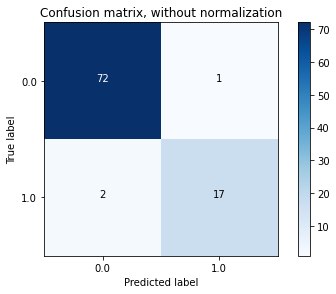

Normalized confusion matrix


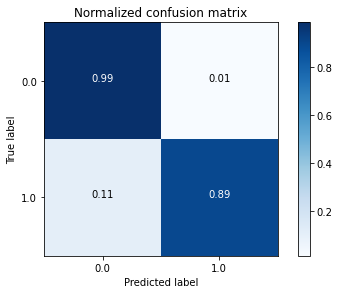

In [69]:
predicted_target, actual_target = evaluate_model(data_1, target_1)
plot_confusion_matrix(predicted_target, actual_target)

### For PP

In [70]:
data_rf = pd.read_csv(r'240905-NTA-Paper2-AnnotatedFeatures-ONLY-LogT-Input.csv', header=0) #Targets: 92 samples X 581 features
#del data_rf[data_rf.columns[0]] #Dropping sample information
#print(data_rf)

In [71]:
#Prompt user for source type of interest (GW, LF, BSL, WWTP, PP or PG)
preferred_type = input("Enter the source type of interest: ")

Enter the source type of interest: PP


In [72]:
#Manipulating data frame based on user input to make "Type" column read 1 for all samples of source of interest and 0 for all other samples
#Set up for binary classification (one-vs-all format)

# Define a function to apply to each row
def set_type(row):
    if row['Type'] == preferred_type:
        return 1
    else:
        return 0

# Create a new column "Type 2" with the updated values
data_rf['Type_2'] = data_rf.apply(set_type, axis=1)
del data_rf[data_rf.columns[0]] #Dropping original type column
#Reordering columns with Type_2 as first column
cols = list(data_rf.columns)
cols = [cols[-1]] + cols[:-1]
data_rf = data_rf[cols]

# Save the updated DataFrame to a new CSV file (if needed)
data_rf.to_csv('sample_data_with_labels_NEW10.csv', index=False)

In [73]:
#Changing pandas data frame to numpy for use in ML
data_rf_np = data_rf.to_numpy()
target_1 = data_rf_np[:,0].reshape(-1,1) #Convert target variables to 2D-array for sci-kit learn
data_1 = data_rf_np[:,1:]
#class_names=np.array([0.0,1.0])
#print(data_1.shape)
#print(data_1)

In [74]:
# Split into test and training, and evaluate optimal hyperparameters for Random Forest
totalR = 10
rs = np.arange(1, totalR + 1)

# Define hyperparameter grid for Logistic Regression
solver = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l1','l2']
C_val = [100, 10, 1.0, 0.1, 0.01]

grid = dict(solver=solver,penalty=penalty,C=C_val)

balanced_accuracy_scorer = make_scorer(balanced_accuracy_score)
# Initialize arrays to store results
test_balanced_accuracy = np.empty(len(rs))
train_balanced_accuracy = np.empty(len(rs))



for j in rs:
    X_train, X_test, y_train, y_test = train_test_split(
        data_1, target_1, test_size=0.2, stratify=target_1, random_state=j)
    
    # Create Random Forest classifier
    rf = LogisticRegression()
    
    # Create repeated stratified k-fold cross-validator
    cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=5, random_state=42)
    
    # Perform hyperparameter tuning with GridSearchCV
    grid_search = GridSearchCV(estimator=rf, param_grid=grid, n_jobs=-1, cv=cv, scoring=balanced_accuracy_scorer, error_score=0)
    grid_result = grid_search.fit(X_train, y_train.ravel())
    
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

    # Get the best Logsistic regression model from GridSearchCV
    best_rf = grid_search.best_estimator_

    # Compute balanced accuracy on the training and test data
    train_predictions = best_rf.predict(X_train)
    test_predictions = best_rf.predict(X_test)
    
    train_ba = balanced_accuracy_score(y_train, train_predictions)
    test_ba = balanced_accuracy_score(y_test, test_predictions)
    
    train_balanced_accuracy[j-1] = train_ba
    test_balanced_accuracy[j-1] = test_ba

C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
150 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueErr

Best: 0.991667 using {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}


C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
150 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueErr

Best: 0.963333 using {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}


C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
150 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueErr

Best: 0.991667 using {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}


C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
150 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueErr

Best: 1.000000 using {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}


C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
150 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueErr

Best: 0.996667 using {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}


C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
150 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueErr

Best: 0.983333 using {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}


C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
150 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueErr

Best: 0.976667 using {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}


C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
150 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueErr

Best: 0.975000 using {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}


C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
150 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueErr

Best: 0.993333 using {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
Best: 0.983333 using {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}


C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
150 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueErr

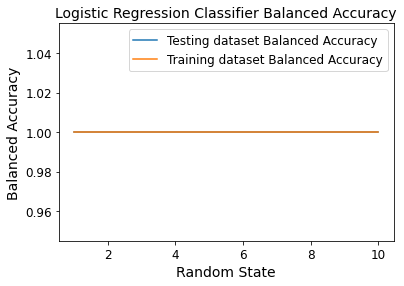

Best Testing Balanced Accuracy: 1.0
Corresponding Random State: 1


In [75]:
# Plot balanced accuracy for different random states
plt.plot(rs, test_balanced_accuracy, label='Testing dataset Balanced Accuracy')
plt.plot(rs, train_balanced_accuracy, label='Training dataset Balanced Accuracy')

plt.legend(fontsize=12)
plt.title('Logistic Regression Classifier Balanced Accuracy', fontsize=14)
plt.xlabel('Random State', fontsize=14)
plt.ylabel('Balanced Accuracy', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig('lR-Tuning-NORM-PP.png', dpi=150, bbox_inches='tight')
plt.show()

# Print the value of best balanced accuracy and the corresponding random state
best_test_balanced_accuracy = np.max(test_balanced_accuracy)
best_random_state = rs[np.argmax(test_balanced_accuracy)]
print("Best Testing Balanced Accuracy:", best_test_balanced_accuracy)
print("Corresponding Random State:", best_random_state)

In [76]:
print(train_balanced_accuracy)
print(test_balanced_accuracy)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


Feature: 0, Score: -0.40735
Feature: 1, Score: -0.13010
Feature: 2, Score: -0.19735
Feature: 3, Score: -0.27028
Feature: 4, Score: -0.11539
Feature: 5, Score: -0.08527
Feature: 6, Score: -0.07570
Feature: 7, Score: 0.02917
Feature: 8, Score: 0.39583
Feature: 9, Score: -0.10206
Feature: 10, Score: -0.23232
Feature: 11, Score: 0.06512
Feature: 12, Score: -0.15459
Feature: 13, Score: -0.36635
Feature: 14, Score: -0.12048
Feature: 15, Score: -0.05598
Feature: 16, Score: -0.06260
Feature: 17, Score: -0.06287
Feature: 18, Score: -0.39262
Feature: 19, Score: 0.07458
Feature: 20, Score: -0.17741
Feature: 21, Score: -0.04938
Feature: 22, Score: -0.04535
Feature: 23, Score: -0.04371
Feature: 24, Score: -0.09803
Feature: 25, Score: -0.29118
Feature: 26, Score: -0.07332
Feature: 27, Score: -0.35549
Feature: 28, Score: 0.20706
Feature: 29, Score: -0.28466
Feature: 30, Score: 0.38930
Feature: 31, Score: -0.04544
Feature: 32, Score: 0.94052
Feature: 33, Score: -0.86782
Feature: 34, Score: -0.04211
Fe

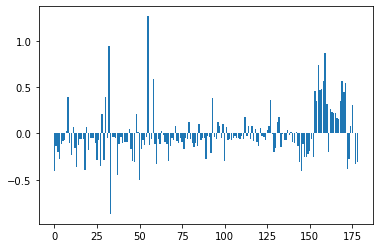

In [77]:
#Now running optimized model over the entire dataset
model = LogisticRegression(solver = 'liblinear', C = 100, penalty = 'l2')
# fit the model
model.fit(data_1, target_1.ravel())

# get importance
importance = model.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

Feature 0: Average Score: -0.40735, Standard Deviation: 0.00000
Feature 1: Average Score: -0.13010, Standard Deviation: 0.00000
Feature 2: Average Score: -0.19735, Standard Deviation: 0.00000
Feature 3: Average Score: -0.27028, Standard Deviation: 0.00000
Feature 4: Average Score: -0.11539, Standard Deviation: 0.00000
Feature 5: Average Score: -0.08527, Standard Deviation: 0.00000
Feature 6: Average Score: -0.07570, Standard Deviation: 0.00000
Feature 7: Average Score: 0.02917, Standard Deviation: 0.00000
Feature 8: Average Score: 0.39583, Standard Deviation: 0.00000
Feature 9: Average Score: -0.10206, Standard Deviation: 0.00000
Feature 10: Average Score: -0.23232, Standard Deviation: 0.00000
Feature 11: Average Score: 0.06512, Standard Deviation: 0.00000
Feature 12: Average Score: -0.15459, Standard Deviation: 0.00000
Feature 13: Average Score: -0.36635, Standard Deviation: 0.00000
Feature 14: Average Score: -0.12048, Standard Deviation: 0.00000
Feature 15: Average Score: -0.05598, S

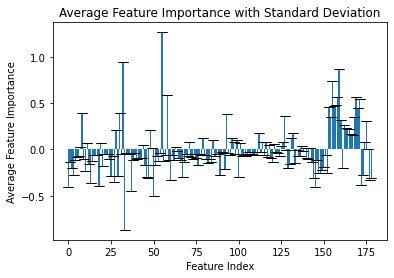

In [78]:
# Initialize variables to store feature importances across iterations
all_importances = []

# Number of iterations
num_iterations = 100

for iteration in range(num_iterations):
    # Create and fit the model
    model = LogisticRegression(solver = 'liblinear', C = 100, penalty = 'l2')
    model.fit(data_1, target_1.ravel())

    # Get importance and store in the list
    importance = model.coef_[0]
    all_importances.append(importance)

# Convert the list to a NumPy array for easy calculations
all_importances = np.array(all_importances)

# Calculate average and standard deviation of feature importances
average_importance = np.mean(all_importances, axis=0)
std_importance = np.std(all_importances, axis=0)

# Summarize and print feature importance statistics
for i, (avg_score, std_score) in enumerate(zip(average_importance, std_importance)):
    print(f'Feature {i}: Average Score: {avg_score:.5f}, Standard Deviation: {std_score:.5f}')

# Plot the average feature importance
plt.bar([x for x in range(len(average_importance))], average_importance, yerr=std_importance, capsize=5)
plt.xlabel('Feature Index')
plt.ylabel('Average Feature Importance')
plt.title('Average Feature Importance with Standard Deviation')
plt.show()

In [79]:
labels_dat = pd.read_csv("240905-NTA-Paper2-AnnotatedFeatures-ONLY-Labels.csv")
feature_names = labels_dat.columns

feature_importance_pairs = [(avg, std, name) for avg, std, name in zip(average_importance, std_importance, feature_names)]

# Sort the list by average importance in descending order
feature_importance_pairs.sort(reverse=True, key=lambda x: x[0])

# Print the output for the top 10 features
print("Top 10 Features:")
for avg, std, name in feature_importance_pairs[:10]:
    print(f'Feature: {name}, Mean Score: {avg:.5f}, Standard Deviation: {std:.5f}')

Top 10 Features:
Feature: 171.138736/11.07, Mean Score: 1.26496, Standard Deviation: 0.00000
Feature: 254.220132/16.9, Mean Score: 0.94052, Standard Deviation: 0.00000
Feature: 251.200899/15.84, Mean Score: 0.86336, Standard Deviation: 0.00000
Feature: 361.237403/16.43, Mean Score: 0.73834, Standard Deviation: 0.00000
Feature: 265.156642/10.93, Mean Score: 0.58937, Standard Deviation: 0.00000
Feature: 241.180143/12.13, Mean Score: 0.57164, Standard Deviation: 0.00000
Feature: 331.083458/6.53, Mean Score: 0.56850, Standard Deviation: 0.00000
Feature: 347.243128/14.76, Mean Score: 0.54272, Standard Deviation: 0.00000
Feature: 301.216358/16.65, Mean Score: 0.48169, Standard Deviation: 0.00000
Feature: 241.087885/8.41, Mean Score: 0.46569, Standard Deviation: 0.00000


In [80]:
labels_dat = pd.read_csv("240905-NTA-Paper2-AnnotatedFeatures-ONLY-Labels.csv")
feature_names = labels_dat.columns

# Get indices of the top 10 features based on mean importance
top_10_indices = np.argsort(average_importance)[::-1][:10]

# Print top 10 features along with their average and standard deviation
print("Top 10 Features:")
for i in top_10_indices:
    print(f'Feature: {feature_names[i]}, Mean Score: {average_importance[i]:.5f}, Standard Deviation: {std_importance[i]:.5f}')

Top 10 Features:
Feature: 171.138736/11.07, Mean Score: 1.26496, Standard Deviation: 0.00000
Feature: 254.220132/16.9, Mean Score: 0.94052, Standard Deviation: 0.00000
Feature: 251.200899/15.84, Mean Score: 0.86336, Standard Deviation: 0.00000
Feature: 361.237403/16.43, Mean Score: 0.73834, Standard Deviation: 0.00000
Feature: 265.156642/10.93, Mean Score: 0.58937, Standard Deviation: 0.00000
Feature: 241.180143/12.13, Mean Score: 0.57164, Standard Deviation: 0.00000
Feature: 331.083458/6.53, Mean Score: 0.56850, Standard Deviation: 0.00000
Feature: 347.243128/14.76, Mean Score: 0.54272, Standard Deviation: 0.00000
Feature: 301.216358/16.65, Mean Score: 0.48169, Standard Deviation: 0.00000
Feature: 241.087885/8.41, Mean Score: 0.46569, Standard Deviation: 0.00000


Top Features with Significant Importance:
1. Feature: 171.138736/11.07, Mean Score: 1.26496, Standard Deviation: 0.00000
2. Feature: 254.220132/16.9, Mean Score: 0.94052, Standard Deviation: 0.00000
3. Feature: 251.200899/15.84, Mean Score: 0.86336, Standard Deviation: 0.00000
4. Feature: 361.237403/16.43, Mean Score: 0.73834, Standard Deviation: 0.00000
5. Feature: 265.156642/10.93, Mean Score: 0.58937, Standard Deviation: 0.00000
6. Feature: 241.180143/12.13, Mean Score: 0.57164, Standard Deviation: 0.00000
7. Feature: 331.083458/6.53, Mean Score: 0.56850, Standard Deviation: 0.00000
8. Feature: 347.243128/14.76, Mean Score: 0.54272, Standard Deviation: 0.00000
9. Feature: 301.216358/16.65, Mean Score: 0.48169, Standard Deviation: 0.00000
10. Feature: 241.087885/8.41, Mean Score: 0.46569, Standard Deviation: 0.00000
11. Feature: 175.097372/6.36, Mean Score: 0.45483, Standard Deviation: 0.00000
12. Feature: 362.969823/9.44, Mean Score: 0.45095, Standard Deviation: 0.00000
13. Feature:

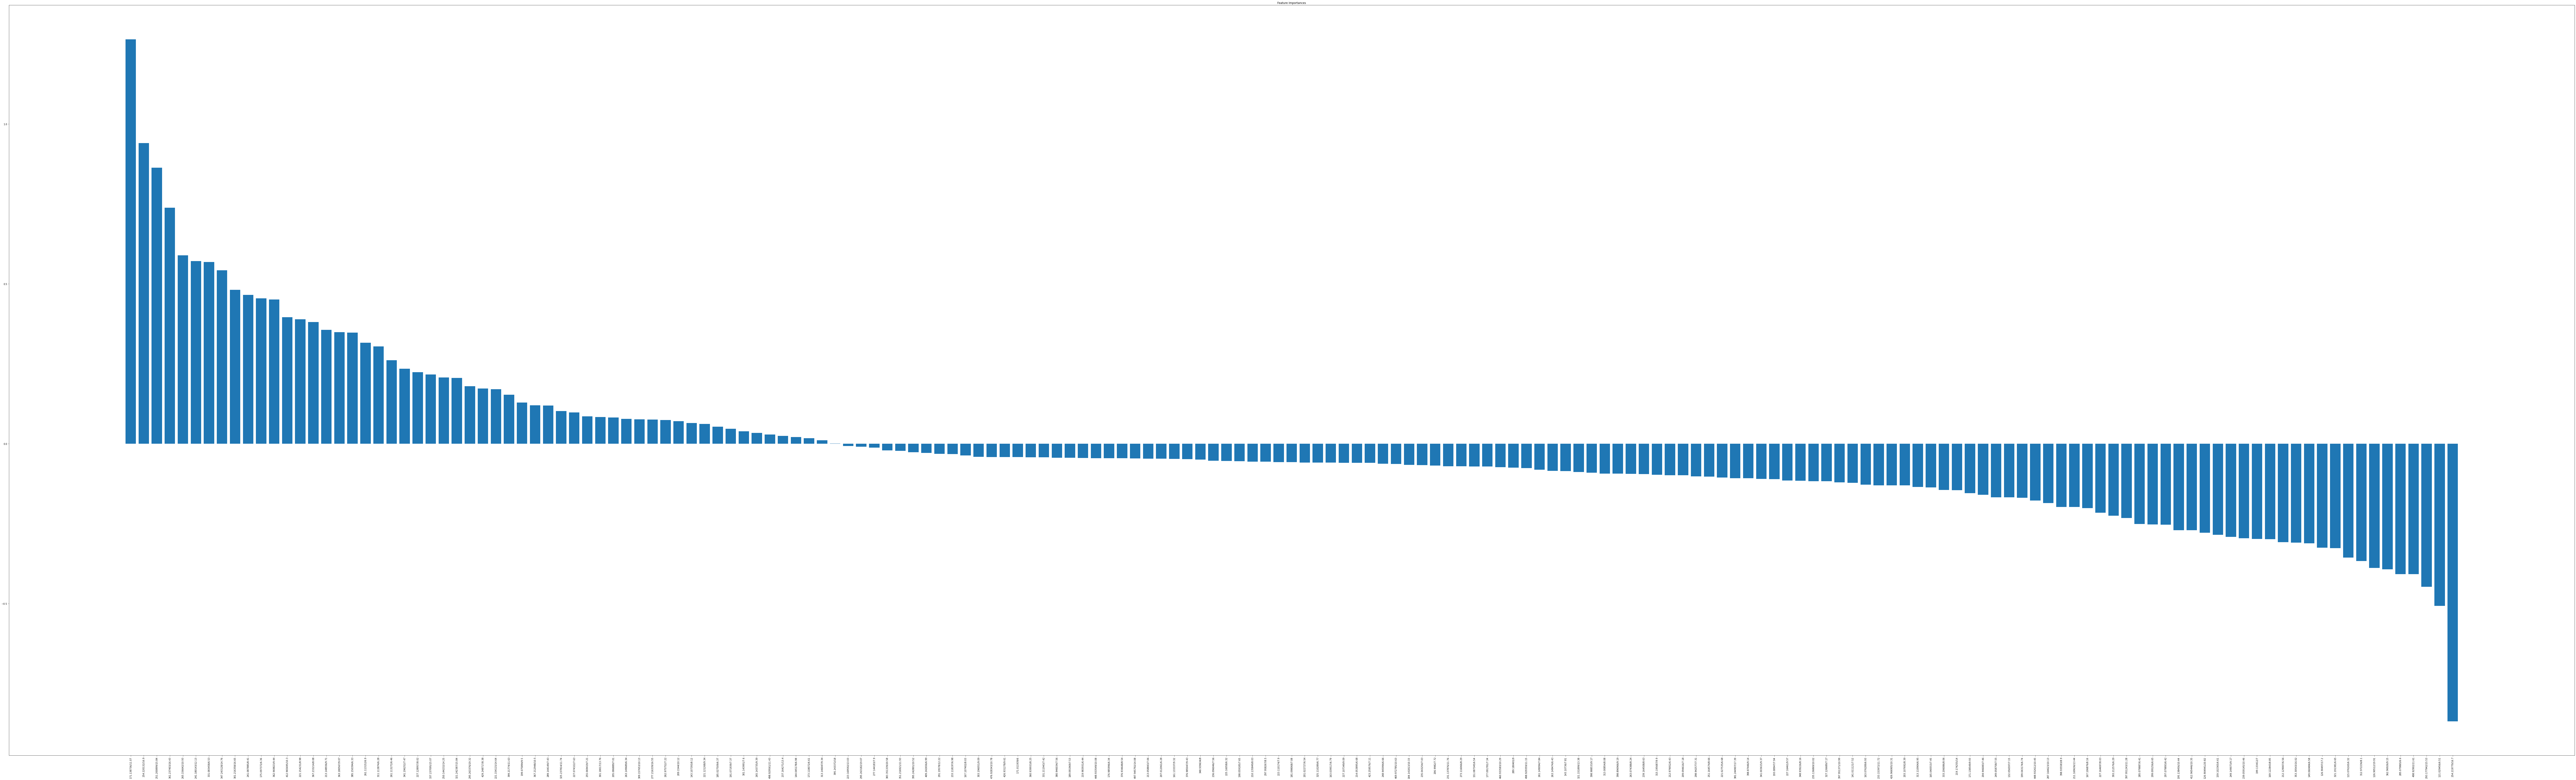

In [81]:
# Rank features by importance
sorted_feature_importance_pairs = sorted(feature_importance_pairs, reverse=True, key=lambda x: x[0])

# Extract feature names and importances
sorted_importances, _, sorted_feature_names = zip(*sorted_feature_importance_pairs)

# Convert feature importances to a numeric data type
sorted_importances = np.array(sorted_importances, dtype=float)

# Calculate the difference between subsequent feature importances
importance_diff = np.diff(sorted_importances)

# Find the index where the largest decrease occurs
largest_decrease_index = np.argmax(importance_diff)


# Store the top features and scores in a DataFrame
df_top_features = pd.DataFrame({'Feature': [], 'Score': []})

# Print the top features until the largest decrease
print("Top Features with Significant Importance:")
for i, (avg, std, name) in enumerate(sorted_feature_importance_pairs[:largest_decrease_index + 1], 1):
    try:
        avg_float = float(avg)
        print(f"{i}. Feature: {name}, Mean Score: {avg_float:.5f}, Standard Deviation: {std:.5f}")
        df_top_features = df_top_features.append({'Feature': name, 'Score': avg_float}, ignore_index=True)
    except ValueError:
        print(f"{i}. Feature: {name}, Mean Score: {avg}, Standard Deviation: {std} (non-numeric)")

# Save the df_top_features DataFrame to an Excel file
df_top_features.to_excel('top_features_scores_norm_WWTP.xlsx', index=False)

# Plot feature importance
plt.figure(figsize=(200, 60))
plt.bar(range(len(sorted_importances)), sorted_importances, tick_label=sorted_feature_names)
plt.xticks(rotation=90)
plt.title("Feature Importances")
# Save the figure as a PNG file
plt.savefig('feature_importances_plot_ORDERED_norm_PP.png', bbox_inches='tight')

# Show the plot (optional)
plt.show()

In [82]:
df = pd.DataFrame({'Importance Difference': importance_diff})
df.to_excel('importance_diff_PP.xlsx', index=False)

In [83]:
class_names=np.array([0.0,1.0])

#Generating confusion matrices (for entire dataset; normalized BAs)
def evaluate_model(data_x, data_y):
    k_fold = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

    predicted_targets = np.array([])
    actual_targets = np.array([])

    for train_ix, test_ix in k_fold.split(data_x, data_y):
        train_x, train_y, test_x, test_y = data_x[train_ix], data_y[train_ix], data_x[test_ix], data_y[test_ix]

        # Fit the classifier
        model_cv = LogisticRegression(solver = 'liblinear', C = 100, penalty = 'l2')
        classifier = model_cv.fit(train_x, train_y.ravel())

        # Predict the labels of the test set samples
        predicted_labels = classifier.predict(test_x)

        predicted_targets = np.append(predicted_targets, predicted_labels)
        actual_targets = np.append(actual_targets, test_y)

    return predicted_targets, actual_targets

In [84]:
def plot_confusion_matrix(predicted_labels_list, y_test_list):
    cnf_matrix = confusion_matrix(y_test_list, predicted_labels_list)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure()
    generate_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix, without normalization')
    plt.show()

    # Plot normalized confusion matrix
    plt.figure()
    generate_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, title='Normalized confusion matrix')
    plt.show()

In [85]:
def generate_confusion_matrix(cnf_matrix, classes, normalize=False, title='Confusion matrix'):
    if normalize:
        cnf_matrix = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cnf_matrix, interpolation='nearest', cmap=plt.get_cmap('Blues'))
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cnf_matrix.max() / 2.
    
    for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        plt.text(j, i, format(cnf_matrix[i, j], fmt), horizontalalignment="center",
                 color="white" if cnf_matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    return cnf_matrix

Confusion matrix, without normalization


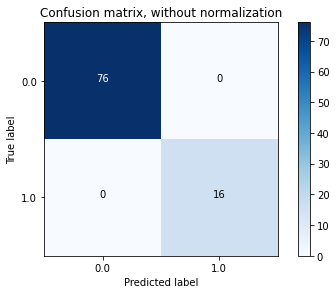

Normalized confusion matrix


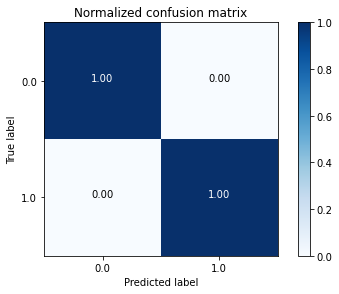

In [86]:
predicted_target, actual_target = evaluate_model(data_1, target_1)
plot_confusion_matrix(predicted_target, actual_target)

### For PG

In [87]:
data_rf = pd.read_csv(r'240905-NTA-Paper2-AnnotatedFeatures-ONLY-LogT-Input.csv', header=0) #Targets: 92 samples X 581 features
#del data_rf[data_rf.columns[0]] #Dropping sample information
#print(data_rf)

In [88]:
#Prompt user for source type of interest (GW, LF, BSL, WWTP, PP or PG)
preferred_type = input("Enter the source type of interest: ")

Enter the source type of interest: PG


In [89]:
#Manipulating data frame based on user input to make "Type" column read 1 for all samples of source of interest and 0 for all other samples
#Set up for binary classification (one-vs-all format)

# Define a function to apply to each row
def set_type(row):
    if row['Type'] == preferred_type:
        return 1
    else:
        return 0

# Create a new column "Type 2" with the updated values
data_rf['Type_2'] = data_rf.apply(set_type, axis=1)
del data_rf[data_rf.columns[0]] #Dropping original type column
#Reordering columns with Type_2 as first column
cols = list(data_rf.columns)
cols = [cols[-1]] + cols[:-1]
data_rf = data_rf[cols]

# Save the updated DataFrame to a new CSV file (if needed)
data_rf.to_csv('sample_data_with_labels_NEW10.csv', index=False)

In [90]:
#Changing pandas data frame to numpy for use in ML
data_rf_np = data_rf.to_numpy()
target_1 = data_rf_np[:,0].reshape(-1,1) #Convert target variables to 2D-array for sci-kit learn
data_1 = data_rf_np[:,1:]
#class_names=np.array([0.0,1.0])
#print(data_1.shape)
#print(data_1)

In [91]:
# Split into test and training, and evaluate optimal hyperparameters for Random Forest
totalR = 10
rs = np.arange(1, totalR + 1)

# Define hyperparameter grid for Logistic Regression
solver = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l1','l2']
C_val = [100, 10, 1.0, 0.1, 0.01]

grid = dict(solver=solver,penalty=penalty,C=C_val)

balanced_accuracy_scorer = make_scorer(balanced_accuracy_score)
# Initialize arrays to store results
test_balanced_accuracy = np.empty(len(rs))
train_balanced_accuracy = np.empty(len(rs))



for j in rs:
    X_train, X_test, y_train, y_test = train_test_split(
        data_1, target_1, test_size=0.2, stratify=target_1, random_state=j)
    
    # Create Random Forest classifier
    rf = LogisticRegression()
    
    # Create repeated stratified k-fold cross-validator
    cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=5, random_state=42)
    
    # Perform hyperparameter tuning with GridSearchCV
    grid_search = GridSearchCV(estimator=rf, param_grid=grid, n_jobs=-1, cv=cv, scoring=balanced_accuracy_scorer, error_score=0)
    grid_result = grid_search.fit(X_train, y_train.ravel())
    
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

    # Get the best Logsistic regression model from GridSearchCV
    best_rf = grid_search.best_estimator_

    # Compute balanced accuracy on the training and test data
    train_predictions = best_rf.predict(X_train)
    test_predictions = best_rf.predict(X_test)
    
    train_ba = balanced_accuracy_score(y_train, train_predictions)
    test_ba = balanced_accuracy_score(y_test, test_predictions)
    
    train_balanced_accuracy[j-1] = train_ba
    test_balanced_accuracy[j-1] = test_ba

C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
150 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueErr

Best: 0.815152 using {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}


C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
150 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueErr

Best: 0.783333 using {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}


C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
150 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueErr

Best: 0.798485 using {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}


C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
150 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueErr

Best: 0.833333 using {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}


C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
150 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueErr

Best: 0.865152 using {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}


C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
150 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueErr

Best: 0.828920 using {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}


C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
150 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueErr

Best: 0.916667 using {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}


C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
150 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueErr

Best: 0.750000 using {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}


C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
150 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueErr

Best: 0.833333 using {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
Best: 0.831884 using {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}


C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
150 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\ntj5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueErr

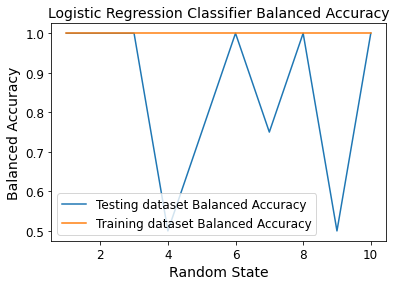

Best Testing Balanced Accuracy: 1.0
Corresponding Random State: 1


In [92]:
# Plot balanced accuracy for different random states
plt.plot(rs, test_balanced_accuracy, label='Testing dataset Balanced Accuracy')
plt.plot(rs, train_balanced_accuracy, label='Training dataset Balanced Accuracy')

plt.legend(fontsize=12)
plt.title('Logistic Regression Classifier Balanced Accuracy', fontsize=14)
plt.xlabel('Random State', fontsize=14)
plt.ylabel('Balanced Accuracy', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig('lR-Tuning-NORM-PG.png', dpi=150, bbox_inches='tight')
plt.show()

# Print the value of best balanced accuracy and the corresponding random state
best_test_balanced_accuracy = np.max(test_balanced_accuracy)
best_random_state = rs[np.argmax(test_balanced_accuracy)]
print("Best Testing Balanced Accuracy:", best_test_balanced_accuracy)
print("Corresponding Random State:", best_random_state)

In [93]:
print(train_balanced_accuracy)
print(test_balanced_accuracy)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1.   1.   1.   0.5  0.75 1.   0.75 1.   0.5  1.  ]


Feature: 0, Score: 0.00000
Feature: 1, Score: 0.00000
Feature: 2, Score: -0.31695
Feature: 3, Score: -0.94856
Feature: 4, Score: 0.00000
Feature: 5, Score: 0.00000
Feature: 6, Score: -0.17586
Feature: 7, Score: -0.45070
Feature: 8, Score: 0.00000
Feature: 9, Score: 0.00000
Feature: 10, Score: 0.00000
Feature: 11, Score: 0.15153
Feature: 12, Score: 0.00000
Feature: 13, Score: -0.33660
Feature: 14, Score: 0.00000
Feature: 15, Score: 0.00000
Feature: 16, Score: 0.00000
Feature: 17, Score: 0.00000
Feature: 18, Score: 0.00000
Feature: 19, Score: 0.00000
Feature: 20, Score: -0.19098
Feature: 21, Score: 0.00000
Feature: 22, Score: 0.00000
Feature: 23, Score: 0.00000
Feature: 24, Score: 0.00000
Feature: 25, Score: -0.01516
Feature: 26, Score: 0.00000
Feature: 27, Score: 0.00000
Feature: 28, Score: 0.00000
Feature: 29, Score: -0.03036
Feature: 30, Score: 0.00000
Feature: 31, Score: 0.00000
Feature: 32, Score: 0.00000
Feature: 33, Score: 1.05580
Feature: 34, Score: 0.00000
Feature: 35, Score: 0.

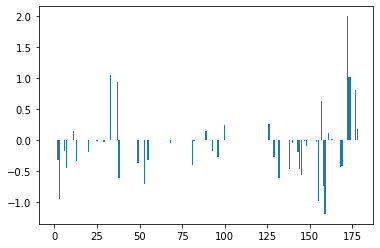

In [94]:
#Now running optimized model over the entire dataset
model = LogisticRegression(solver = 'liblinear', C = 100, penalty = 'l1')
# fit the model
model.fit(data_1, target_1.ravel())

# get importance
importance = model.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

Feature 0: Average Score: 0.00000, Standard Deviation: 0.00000
Feature 1: Average Score: 0.00000, Standard Deviation: 0.00000
Feature 2: Average Score: -0.21885, Standard Deviation: 0.09300
Feature 3: Average Score: -1.28547, Standard Deviation: 0.17364
Feature 4: Average Score: -0.01222, Standard Deviation: 0.03648
Feature 5: Average Score: 0.00000, Standard Deviation: 0.00000
Feature 6: Average Score: -0.00844, Standard Deviation: 0.02557
Feature 7: Average Score: -0.20075, Standard Deviation: 0.15939
Feature 8: Average Score: 0.00000, Standard Deviation: 0.00000
Feature 9: Average Score: 0.00000, Standard Deviation: 0.00000
Feature 10: Average Score: -0.00169, Standard Deviation: 0.00475
Feature 11: Average Score: 0.13790, Standard Deviation: 0.06808
Feature 12: Average Score: 0.00001, Standard Deviation: 0.00008
Feature 13: Average Score: -0.31196, Standard Deviation: 0.05000
Feature 14: Average Score: -0.00031, Standard Deviation: 0.00181
Feature 15: Average Score: -0.01192, Stand

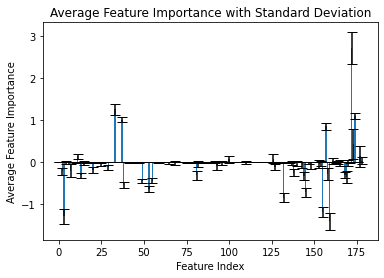

In [95]:
# Initialize variables to store feature importances across iterations
all_importances = []

# Number of iterations
num_iterations = 100

for iteration in range(num_iterations):
    # Create and fit the model
    model = LogisticRegression(solver = 'liblinear', C = 100, penalty = 'l1')
    model.fit(data_1, target_1.ravel())

    # Get importance and store in the list
    importance = model.coef_[0]
    all_importances.append(importance)

# Convert the list to a NumPy array for easy calculations
all_importances = np.array(all_importances)

# Calculate average and standard deviation of feature importances
average_importance = np.mean(all_importances, axis=0)
std_importance = np.std(all_importances, axis=0)

# Summarize and print feature importance statistics
for i, (avg_score, std_score) in enumerate(zip(average_importance, std_importance)):
    print(f'Feature {i}: Average Score: {avg_score:.5f}, Standard Deviation: {std_score:.5f}')

# Plot the average feature importance
plt.bar([x for x in range(len(average_importance))], average_importance, yerr=std_importance, capsize=5)
plt.xlabel('Feature Index')
plt.ylabel('Average Feature Importance')
plt.title('Average Feature Importance with Standard Deviation')
plt.show()

In [96]:
labels_dat = pd.read_csv("240905-NTA-Paper2-AnnotatedFeatures-ONLY-Labels.csv")
feature_names = labels_dat.columns

feature_importance_pairs = [(avg, std, name) for avg, std, name in zip(average_importance, std_importance, feature_names)]

# Sort the list by average importance in descending order
feature_importance_pairs.sort(reverse=True, key=lambda x: x[0])

# Print the output for the top 10 features
print("Top 10 Features:")
for avg, std, name in feature_importance_pairs[:10]:
    print(f'Feature: {name}, Mean Score: {avg:.5f}, Standard Deviation: {std:.5f}')

Top 10 Features:
Feature: 126.90512/19.91, Mean Score: 2.70866, Standard Deviation: 0.37792
Feature: 254.219779/16.7, Mean Score: 1.26186, Standard Deviation: 0.13180
Feature: 309.157653/10.13, Mean Score: 1.10242, Standard Deviation: 0.07871
Feature: 293.177942/15.53, Mean Score: 1.01539, Standard Deviation: 0.07008
Feature: 301.216358/16.65, Mean Score: 0.85543, Standard Deviation: 0.08708
Feature: 126.904941/20.82, Mean Score: 0.43806, Standard Deviation: 0.35338
Feature: 126.90497/17.2, Mean Score: 0.14215, Standard Deviation: 0.24670
Feature: 143.107393/8.12, Mean Score: 0.13790, Standard Deviation: 0.06808
Feature: 277.216339/16.55, Mean Score: 0.08319, Standard Deviation: 0.10890
Feature: 199.133412/7, Mean Score: 0.07024, Standard Deviation: 0.08033


In [97]:
labels_dat = pd.read_csv("240905-NTA-Paper2-AnnotatedFeatures-ONLY-Labels.csv")
feature_names = labels_dat.columns

# Get indices of the top 10 features based on mean importance
top_10_indices = np.argsort(average_importance)[::-1][:10]

# Print top 10 features along with their average and standard deviation
print("Top 10 Features:")
for i in top_10_indices:
    print(f'Feature: {feature_names[i]}, Mean Score: {average_importance[i]:.5f}, Standard Deviation: {std_importance[i]:.5f}')

Top 10 Features:
Feature: 126.90512/19.91, Mean Score: 2.70866, Standard Deviation: 0.37792
Feature: 254.219779/16.7, Mean Score: 1.26186, Standard Deviation: 0.13180
Feature: 309.157653/10.13, Mean Score: 1.10242, Standard Deviation: 0.07871
Feature: 293.177942/15.53, Mean Score: 1.01539, Standard Deviation: 0.07008
Feature: 301.216358/16.65, Mean Score: 0.85543, Standard Deviation: 0.08708
Feature: 126.904941/20.82, Mean Score: 0.43806, Standard Deviation: 0.35338
Feature: 126.90497/17.2, Mean Score: 0.14215, Standard Deviation: 0.24670
Feature: 143.107393/8.12, Mean Score: 0.13790, Standard Deviation: 0.06808
Feature: 277.216339/16.55, Mean Score: 0.08319, Standard Deviation: 0.10890
Feature: 199.133412/7, Mean Score: 0.07024, Standard Deviation: 0.08033


Top Features with Significant Importance:
1. Feature: 126.90512/19.91, Mean Score: 2.70866, Standard Deviation: 0.37792
2. Feature: 254.219779/16.7, Mean Score: 1.26186, Standard Deviation: 0.13180
3. Feature: 309.157653/10.13, Mean Score: 1.10242, Standard Deviation: 0.07871
4. Feature: 293.177942/15.53, Mean Score: 1.01539, Standard Deviation: 0.07008
5. Feature: 301.216358/16.65, Mean Score: 0.85543, Standard Deviation: 0.08708
6. Feature: 126.904941/20.82, Mean Score: 0.43806, Standard Deviation: 0.35338
7. Feature: 126.90497/17.2, Mean Score: 0.14215, Standard Deviation: 0.24670
8. Feature: 143.107393/8.12, Mean Score: 0.13790, Standard Deviation: 0.06808
9. Feature: 277.216339/16.55, Mean Score: 0.08319, Standard Deviation: 0.10890
10. Feature: 199.133412/7, Mean Score: 0.07024, Standard Deviation: 0.08033
11. Feature: 353.30543/16.02, Mean Score: 0.04108, Standard Deviation: 0.08687
12. Feature: 211.169636/13.44, Mean Score: 0.03659, Standard Deviation: 0.06822
13. Feature: 227.

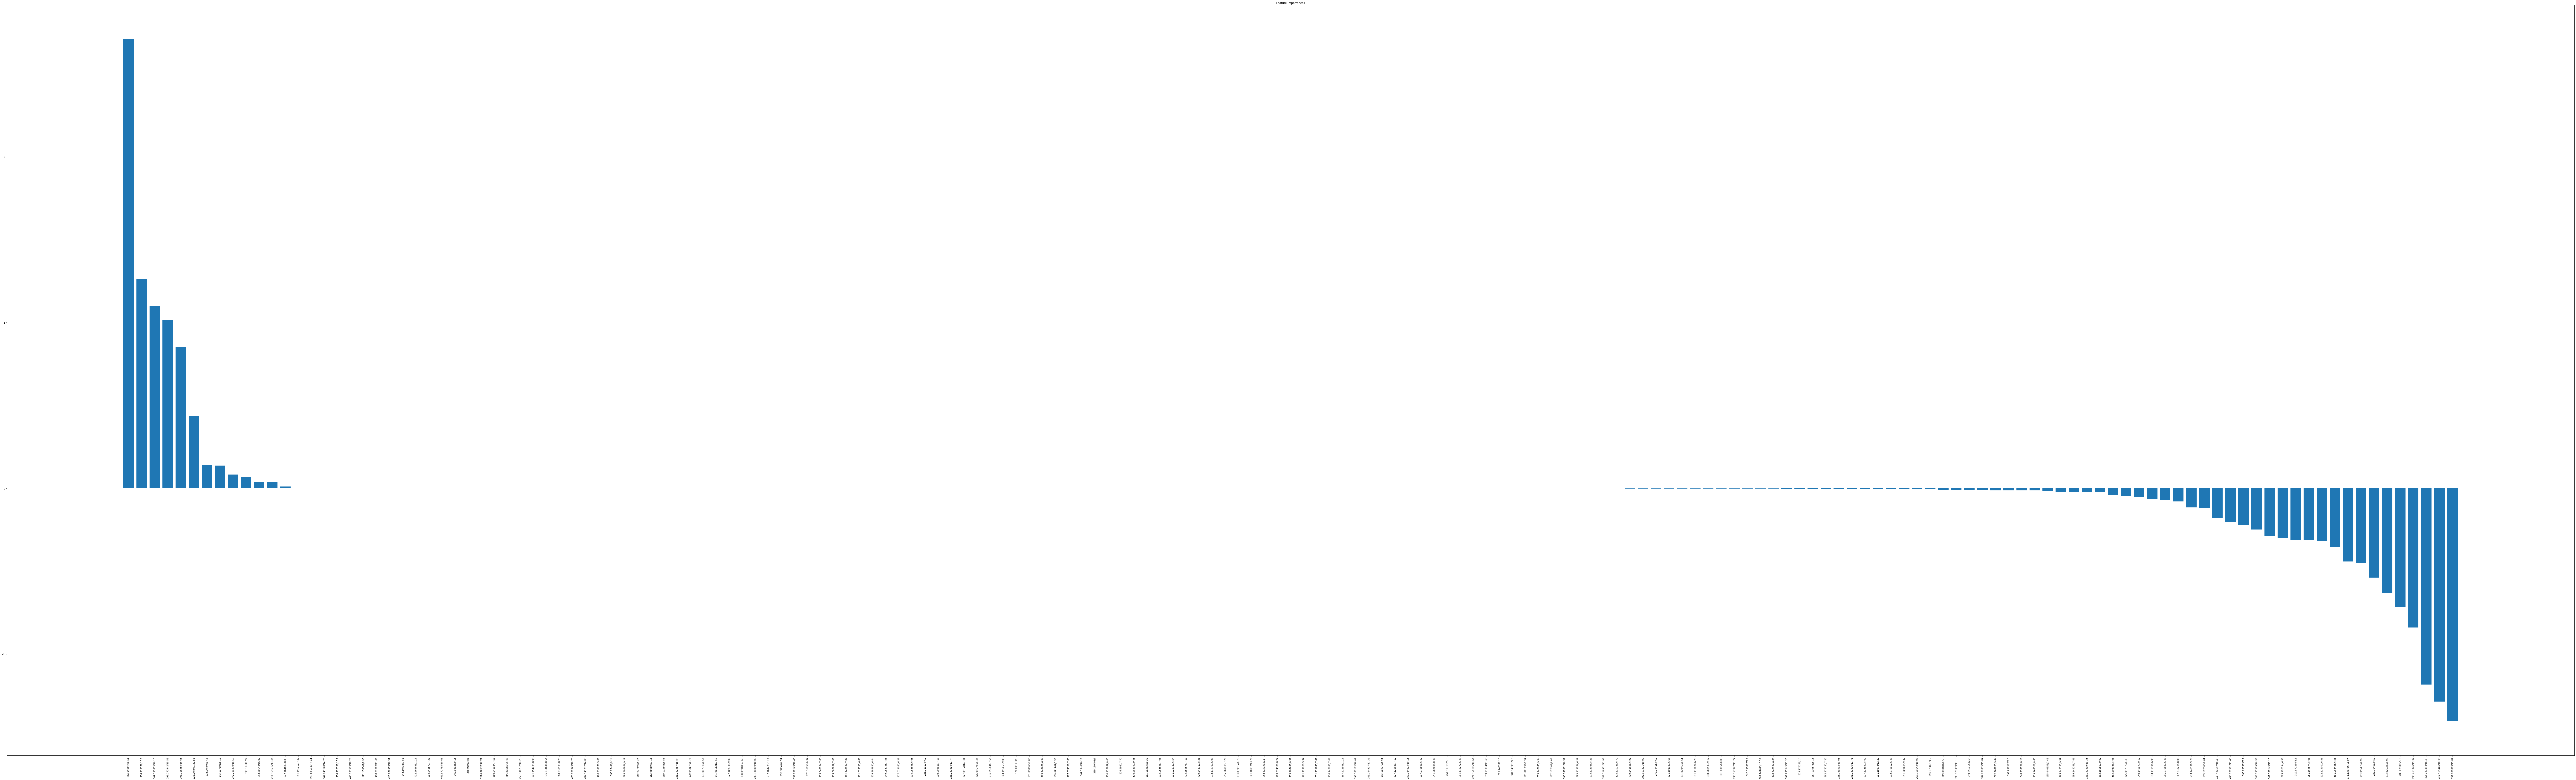

In [98]:
# Rank features by importance
sorted_feature_importance_pairs = sorted(feature_importance_pairs, reverse=True, key=lambda x: x[0])

# Extract feature names and importances
sorted_importances, _, sorted_feature_names = zip(*sorted_feature_importance_pairs)

# Convert feature importances to a numeric data type
sorted_importances = np.array(sorted_importances, dtype=float)

# Calculate the difference between subsequent feature importances
importance_diff = np.diff(sorted_importances)

# Find the index where the largest decrease occurs
largest_decrease_index = np.argmax(importance_diff)


# Store the top features and scores in a DataFrame
df_top_features = pd.DataFrame({'Feature': [], 'Score': []})

# Print the top features until the largest decrease
print("Top Features with Significant Importance:")
for i, (avg, std, name) in enumerate(sorted_feature_importance_pairs[:largest_decrease_index + 1], 1):
    try:
        avg_float = float(avg)
        print(f"{i}. Feature: {name}, Mean Score: {avg_float:.5f}, Standard Deviation: {std:.5f}")
        df_top_features = df_top_features.append({'Feature': name, 'Score': avg_float}, ignore_index=True)
    except ValueError:
        print(f"{i}. Feature: {name}, Mean Score: {avg}, Standard Deviation: {std} (non-numeric)")

# Save the df_top_features DataFrame to an Excel file
df_top_features.to_excel('top_features_scores_norm_PG.xlsx', index=False)

# Plot feature importance
plt.figure(figsize=(200, 60))
plt.bar(range(len(sorted_importances)), sorted_importances, tick_label=sorted_feature_names)
plt.xticks(rotation=90)
plt.title("Feature Importances")
# Save the figure as a PNG file
plt.savefig('feature_importances_plot_ORDERED_norm_PG.png', bbox_inches='tight')

# Show the plot (optional)
plt.show()

In [99]:
df = pd.DataFrame({'Importance Difference': importance_diff})
df.to_excel('importance_diff_PG.xlsx', index=False)

In [100]:
class_names=np.array([0.0,1.0])

#Generating confusion matrices (for entire dataset; normalized BAs)
def evaluate_model(data_x, data_y):
    k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

    predicted_targets = np.array([])
    actual_targets = np.array([])

    for train_ix, test_ix in k_fold.split(data_x, data_y):
        train_x, train_y, test_x, test_y = data_x[train_ix], data_y[train_ix], data_x[test_ix], data_y[test_ix]

        # Fit the classifier
        model_cv = LogisticRegression(solver = 'liblinear', C = 100, penalty = 'l1')
        classifier = model_cv.fit(train_x, train_y.ravel())

        # Predict the labels of the test set samples
        predicted_labels = classifier.predict(test_x)

        predicted_targets = np.append(predicted_targets, predicted_labels)
        actual_targets = np.append(actual_targets, test_y)

    return predicted_targets, actual_targets

In [101]:
def plot_confusion_matrix(predicted_labels_list, y_test_list):
    cnf_matrix = confusion_matrix(y_test_list, predicted_labels_list)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure()
    generate_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix, without normalization')
    plt.show()

    # Plot normalized confusion matrix
    plt.figure()
    generate_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, title='Normalized confusion matrix')
    plt.show()

In [102]:
def generate_confusion_matrix(cnf_matrix, classes, normalize=False, title='Confusion matrix'):
    if normalize:
        cnf_matrix = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cnf_matrix, interpolation='nearest', cmap=plt.get_cmap('Blues'))
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cnf_matrix.max() / 2.
    
    for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        plt.text(j, i, format(cnf_matrix[i, j], fmt), horizontalalignment="center",
                 color="white" if cnf_matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    return cnf_matrix

Confusion matrix, without normalization


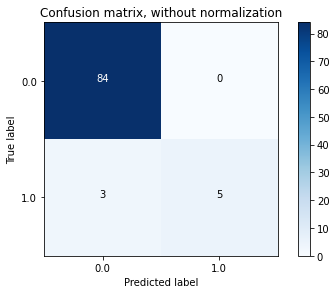

Normalized confusion matrix


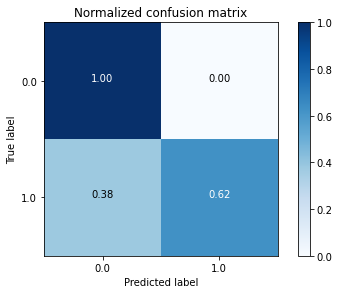

In [103]:
predicted_target, actual_target = evaluate_model(data_1, target_1)
plot_confusion_matrix(predicted_target, actual_target)